# Comparing importance scores with metrics like correlation & JSD

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm

import sys
sys.path.append('/home/katie/bp_repo/multitask_profile_model_SPI_GATA/')
from plotting_helper import *
from all_functions import *
from profile_models import ModelLoader
import profile_performance
from profile_performance import *
os.chdir('/home/katie/bp_repo/reports/')
from util import import_shap_scores, import_profiles
from viz_sequence import plot_weights

tqdm.tqdm_notebook()

plt.rcParams["figure.dpi"] = 130

/tmp/ipykernel_7868/379311264.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

## Create and pickle importance scores dicts if needed

In [3]:
# pickle the imp scores :)
path = '/home/katie/bp_repo/pipeline_outputs/'
date = 'jul16'

tfs = ['ctcf', 'fosl2']
models = ['chipseq', 'cutnrun']
subsets = ['chip_shared', 'cut_shared', 'chip_unique', 'cut_unique']

scores_dict = {'hyp_scores':{}, 'act_scores':{}}

In [74]:
for tf in tfs:
    scores_dict['hyp_scores'][tf], scores_dict['act_scores'][tf] = {}, {}
    for model in models:
        scores_dict['hyp_scores'][tf][model], scores_dict['act_scores'][tf][model] = {}, {}
        for subset in subsets:
            scores_dict['hyp_scores'][tf][model][subset], scores_dict['act_scores'][tf][model][subset] = {}, {}
            # load in hyp and act scores
            scores_dict['hyp_scores'][tf][model][subset], scores_dict['act_scores'][tf][model][subset],_,_ = \
                         import_shap_scores(f'{path}{tf}_{model}_{date}/{subset}/shap_scores', hyp_score_key="hyp_scores",
                             center_cut_size=400, remove_non_acgt=False)
            
            # load in coords and subset hyp and act scores to unique peaks
            coords = pd.DataFrame()
            coords[0] = np.array(h5py.File(f'{path}{tf}_{model}_{date}/{subset}/shap_scores', 'r')['coords_chrom']).astype(str)
            coords[1] = np.array(h5py.File(f'{path}{tf}_{model}_{date}/{subset}/shap_scores', 'r')['coords_start'])
            coords[2] = np.array(h5py.File(f'{path}{tf}_{model}_{date}/{subset}/shap_scores', 'r')['coords_end'])
            
            indexes_unique = list(coords.drop_duplicates().index)
            scores_dict['hyp_scores'][tf][model][subset] = scores_dict['hyp_scores'][tf][model][subset][indexes_unique]
            scores_dict['act_scores'][tf][model][subset] = scores_dict['act_scores'][tf][model][subset][indexes_unique]
            
pickle.dump(scores_dict, 
    open(f'/home/katie/bp_repo/reports/katie_notebooks/summer2022_analysis/imp_scores_dicts/{date}.dict', 'wb'))

Importing SHAP scores: 100%|████████████████████| 41/41 [00:00<00:00, 56.84it/s]


## Load in importance scores and set variables

In [37]:
# load in importance scores
scores = pickle.load(open('/home/katie/bp_repo/reports/katie_notebooks/summer2022_analysis/imp_scores_dicts/jul16.dict', 'rb'))
act_scores = scores['act_scores']
hyp_scores = scores['hyp_scores']

In [10]:
pretty_subsets = ['ChIP-seq shared peaks', 'CUT&RUN shared peaks', 'ChIP-seq unique peaks', 'CUT&RUN unique peaks']
metrics = ['Pearson on act scores', 'Pearson on act scores (CDF)', 'JSD on act scores', 'Continuous Jaccard similarity on hyp scores', 
           'Continuous Jaccard similarity on hyp scores (CDF)', 'Pearson on hyp scores', 'Pearson on hyp scores (CDF)', 'JSD on hyp scores']
means = pd.DataFrame(columns=list('Mean ' + i for i in metrics if i not in ['Pearson on act scores (CDF)',
                      'Continuous Jaccard similarity on hyp scores (CDF)', 'Pearson on hyp scores (CDF)']), 
                     index=pd.MultiIndex.from_product((list(tf.upper() for tf in tfs), pretty_subsets)))

colors = ['darkorange', 'firebrick', 'aqua', 'blue']

def plot_metrics(tf, metric):
    rects_values = list(means.loc[(tf, subset), metric] for subset in pretty_subsets)
    
    width = 0.7       # the width of the bars: can also be len(x) sequence
    ind = np.arange(len(pretty_subsets))

    fig, ax = plt.subplots()

    rects = ax.bar(ind, rects_values, width)

    ax.set_xticks(ind, pretty_subsets, rotation=30)
    ax.set_xlabel('Peak subset')
    ax.set_ylabel(metric)
    ax.set_title(f"{tf} mean similarity")
    
    ax.bar_label(rects, padding=1, fontsize=8)

    plt.show()

## Pearson on *actual* importance scores

In [11]:
# actual scores have 3 0's and 1 non-zero value for each base position, so we sum across this axis to 
# just keep that single non-zero value

for tf in tfs:
    for model in models:
        for subset in subsets:
            act_scores[tf][model][subset] = np.sum(act_scores[tf][model][subset], axis=2)  

In [12]:
# now we run the pearson_corr function, which computes correlation across this last dimension
pearson_act_scores = {}

for tf in tfs:
    pearson_act_scores[tf] = {}
    for subset in subsets:
        pearson_act_scores[tf][subset] = pearson_corr(act_scores[tf]['chipseq'][subset], act_scores[tf]['cutnrun'][subset])

<Figure size 780x520 with 0 Axes>

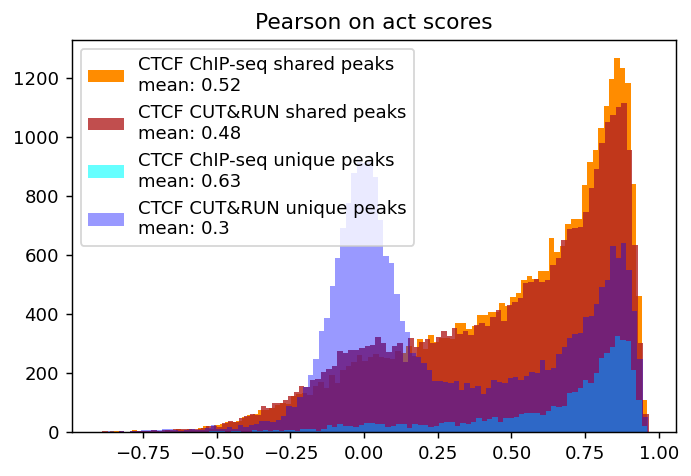

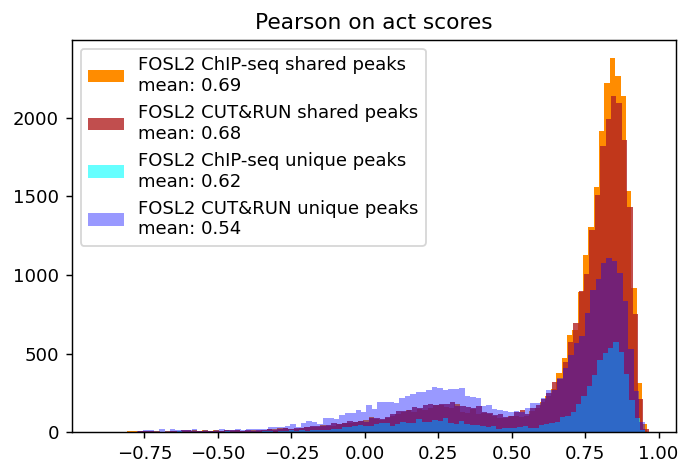

In [107]:
# plot distribution of correlations (across each CTCF subset)
fig = plt.figure()
for tf in tfs:
    plt.figure()
    for i in range(4):
        mean = np.round(np.mean(pearson_act_scores[tf][subsets[i]]), 2)
        plt.hist(pearson_act_scores[tf][subsets[i]], bins=100, alpha=1-0.2*i, label=f'{tf.upper()} {pretty_subsets[i]}\nmean: {mean}',
                color=colors[i])
        means.loc[(tf.upper(), pretty_subsets[i]), 'Mean Pearson on act scores'] = mean
    plt.legend()
    plt.title(metrics[0])

<Figure size 780x520 with 0 Axes>

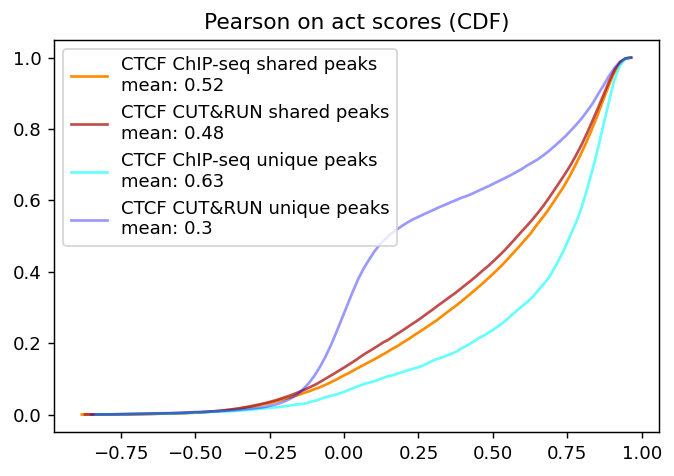

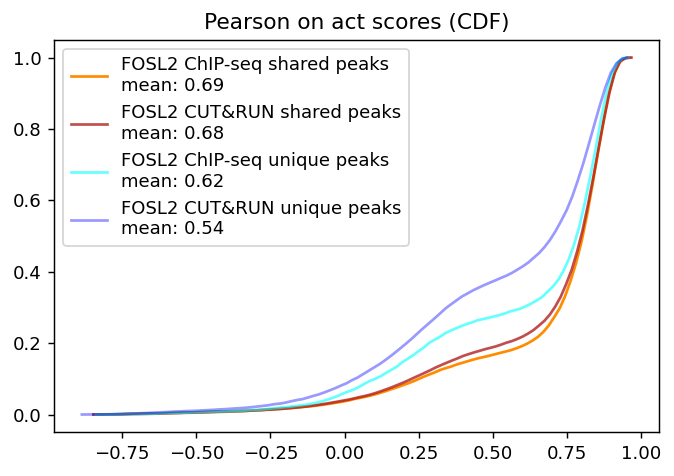

In [162]:
# plot cumulative distribution (CDF) of correlations
fig = plt.figure()
for tf in tfs:
    plt.figure()
    for i in range(4):
        mean = np.round(np.mean(pearson_act_scores[tf][subsets[i]]), 2)
        count, bins_count = np.histogram(pearson_act_scores[tf][subsets[i]], bins=100)
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        plt.plot(bins_count[1:], cdf, alpha=1-0.20*i, label=f'{tf.upper()} {pretty_subsets[i]}\nmean: {mean}', color=colors[i])
    plt.legend()
    plt.title(metrics[1])

## JSD on *actual* importance scores

In [13]:
# now we run the jensen_shannon_distance function, which computes JSD across this last dimension
# n.b. we must take the absolute value of everything before computing JSD!!
jsd_act_scores = {}

for tf in tfs:
    jsd_act_scores[tf] = {}
    for subset in subsets:
        jsd_act_scores[tf][subset] = jensen_shannon_distance(np.abs(act_scores[tf]['chipseq'][subset]), np.abs(act_scores[tf]['cutnrun'][subset]))

<Figure size 780x520 with 0 Axes>

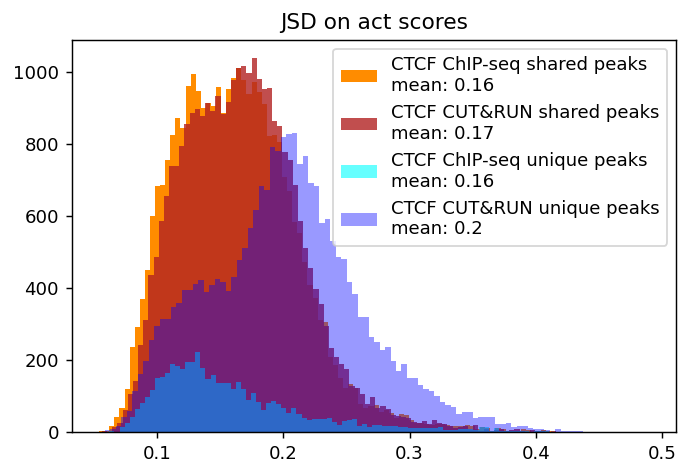

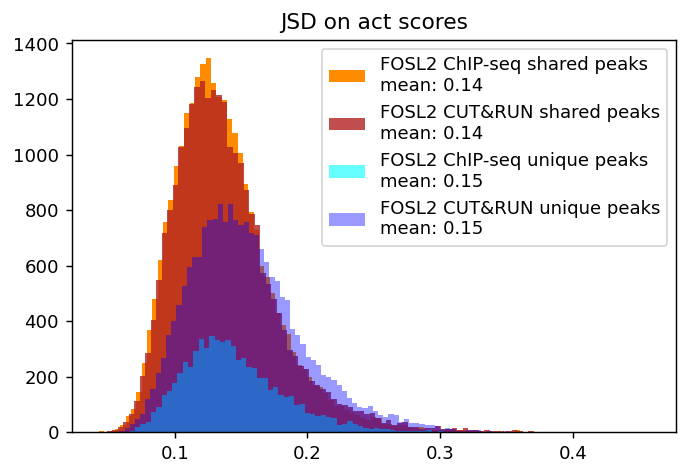

In [117]:
# plot distribution of correlations
fig = plt.figure()
for tf in tfs:
    fig = plt.figure()
    for i in range(4):
        mean = np.round(np.mean(jsd_act_scores[tf][subsets[i]]), 2)
        plt.hist(jsd_act_scores[tf][subsets[i]], bins=100, alpha=1-0.2*i, label=f'{tf.upper()} {pretty_subsets[i]}\nmean: {mean}',
                color=colors[i])
        means.loc[(tf.upper(), pretty_subsets[i]), 'Mean JSD on act scores'] = mean
    plt.legend()
    plt.title(metrics[2])

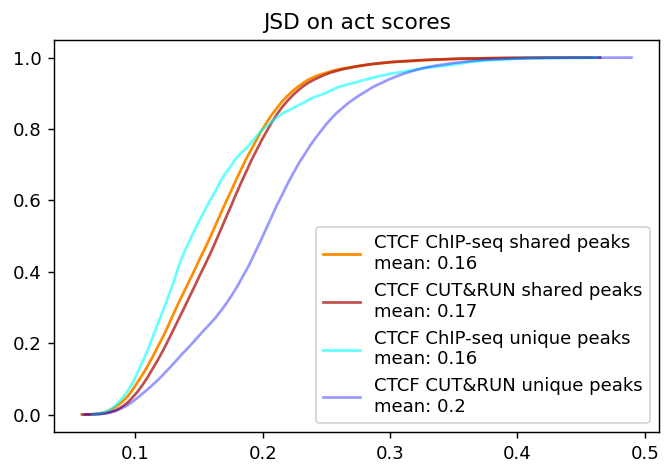

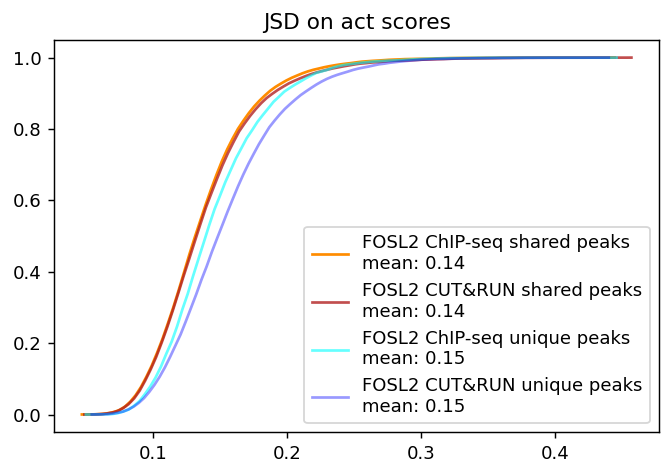

In [168]:
# plot cumulative distribution (CDF) of JSDs
for tf in tfs:
    fig = plt.figure()
    for i in range(0,4):
        mean = np.round(np.mean(jsd_act_scores[tf][subsets[i]]), 2)
        count, bins_count = np.histogram(jsd_act_scores[tf][subsets[i]], bins=100)
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        plt.plot(bins_count[1:], cdf, alpha=1-0.2*i, label=f'{tf.upper()} {pretty_subsets[i]}\nmean: {mean}', color=colors[i%4])
    plt.legend()
    plt.title(metrics[2])

## Continuous jaccard similarity on *hypothetical* importance scores

In [14]:
def cont_jaccard(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a continuous Jaccard metric.
    """
    # L1-normalize
    norm_1 = np.sum(np.abs(seq_1), axis=1, keepdims=True)
    norm_2 = np.sum(np.abs(seq_2), axis=1, keepdims=True)
    norm_1[norm_1 == 0] = 1
    norm_2[norm_2 == 0] = 1
    seq_1 = seq_1 / norm_1
    seq_2 = seq_2 / norm_2
    
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.sum(np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2), axis=1)
    union = np.sum(np.maximum(ab_1, ab_2), axis=1)
    zero_mask = union == 0
    inter[zero_mask] = 0
    union[zero_mask] = 1
    return np.sum(inter / union)

In [15]:
jaccard_hyp_scores = {}

for tf in tfs:
    jaccard_hyp_scores[tf] = {}
    for subset in subsets:
        jaccard_hyp_scores[tf][subset] = list(cont_jaccard( hyp_scores[tf]['chipseq'][subset][i], 
                                            hyp_scores[tf]['cutnrun'][subset][i] ) for i in range(len(hyp_scores[tf]['chipseq'][subset])))

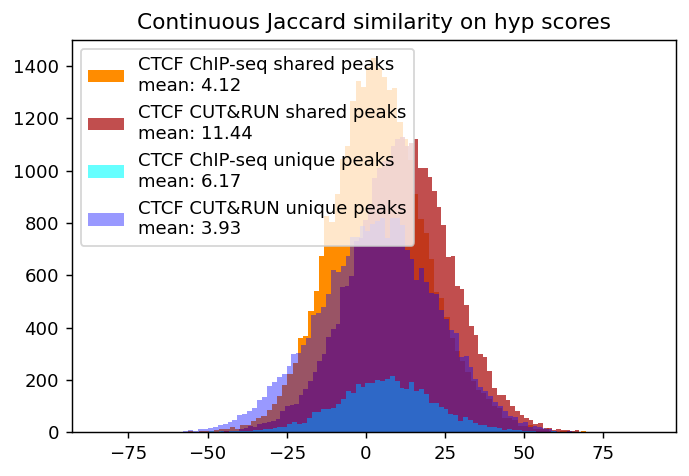

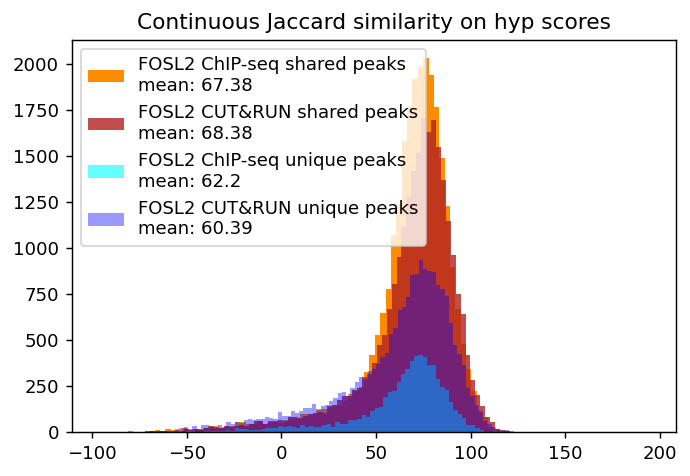

In [133]:
# plot distribution of correlations
for tf in tfs:
    fig = plt.figure()
    for i in range(4):
        mean = np.round(np.mean(jaccard_hyp_scores[tf][subsets[i]]), 2)
        plt.hist(jaccard_hyp_scores[tf][subsets[i]], bins=100, alpha=1-0.2*i, label=f'{tf.upper()} {pretty_subsets[i]}\nmean: {mean}',
                color=colors[i])
        means.loc[(tf.upper(), pretty_subsets[i]), 'Mean Continuous Jaccard similarity on hyp scores'] = mean
    plt.legend()
    plt.title(metrics[3])

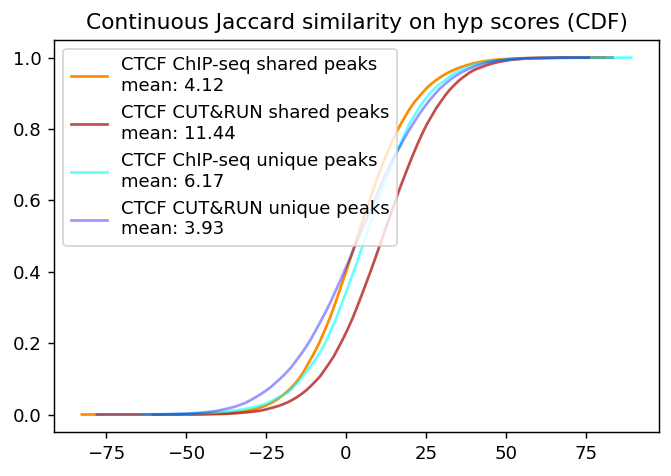

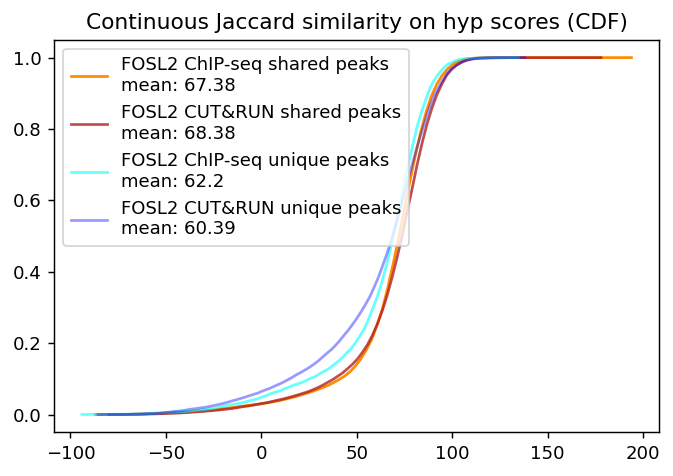

In [134]:
# plot cumulative distribution (CDF) of correlations
for tf in tfs:
    fig = plt.figure()
    for i in range(0,4):
        mean = np.round(np.mean(jaccard_hyp_scores[tf][subsets[i]]), 2)
        count, bins_count = np.histogram(jaccard_hyp_scores[tf][subsets[i]], bins=100)
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        plt.plot(bins_count[1:], cdf, alpha=1-0.2*i, label=f'{tf.upper()} {pretty_subsets[i]}\nmean: {mean}', color=colors[i%4])
    plt.legend()
    plt.title(metrics[4])

## Pearson on *hypothetical* importance scores

In [136]:
# to do stuff on hyp scores, we need to flatten the last two dimensions (400 x 4) into one dimension (1600)
for tf in tfs:
    for model in models:
        for subset in subsets:
            hyp_scores[tf][model][subset] = hyp_scores[tf][model][subset].reshape((-1, 1600))

In [137]:
# now we run the pearson_corr function, which computes correlation across this last dimension
pearson_hyp_scores = {}
for tf in tfs:
    pearson_hyp_scores[tf] = {}
    for subset in subsets:
        pearson_hyp_scores[tf][subset] = pearson_corr(hyp_scores[tf]['chipseq'][subset], hyp_scores[tf]['cutnrun'][subset])

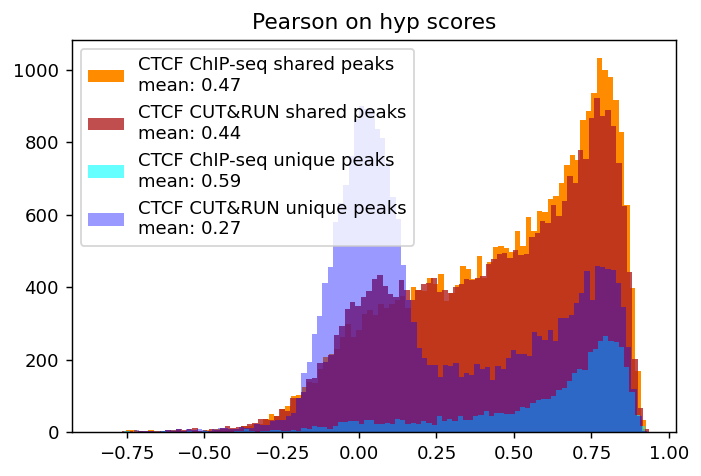

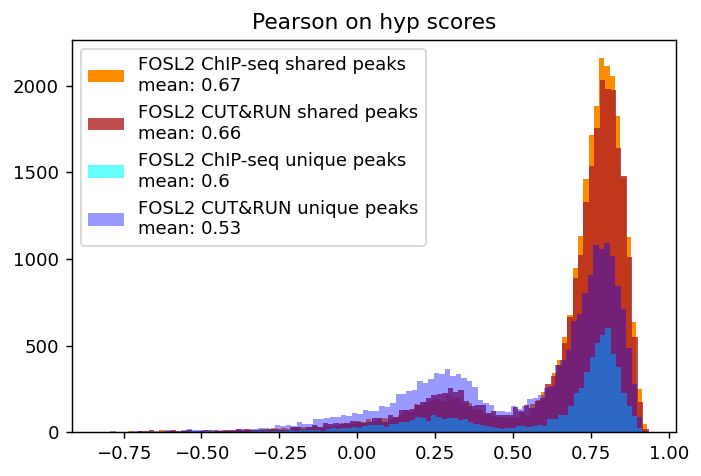

In [163]:
# plot distribution of correlations
for tf in tfs:
    fig = plt.figure()
    for i in range(4):
        mean = np.round(np.mean(pearson_hyp_scores[tf][subsets[i]]), 2)
        plt.hist(pearson_hyp_scores[tf][subsets[i]], bins=100, alpha=1-0.2*i, label=f'{tf.upper()} {pretty_subsets[i]}\nmean: {mean}',
                color=colors[i])
        means.loc[(tf.upper(), pretty_subsets[i]), 'Mean Pearson on hyp scores'] = mean
    plt.legend()
    plt.title(metrics[5])

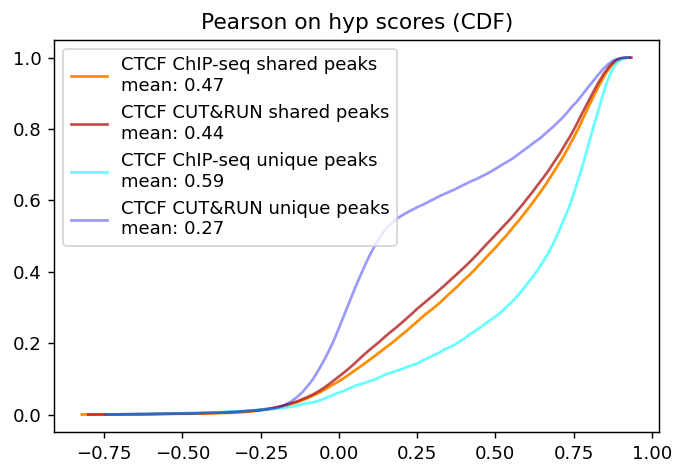

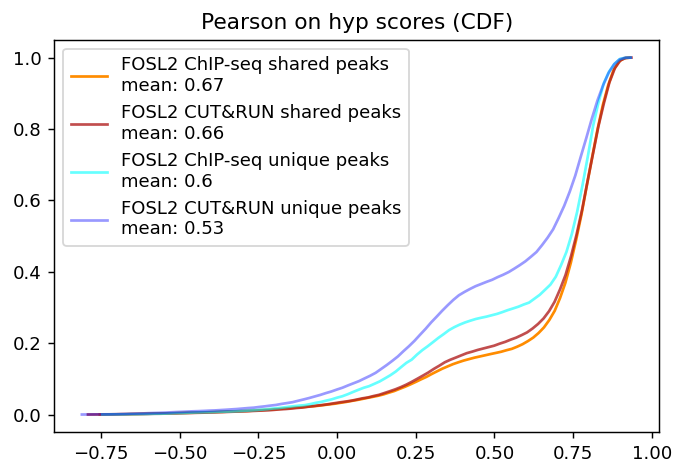

In [141]:
# plot cumulative distribution (CDF) of correlations
for tf in tfs:
    fig = plt.figure()
    for i in range(4):
        mean = np.round(np.mean(pearson_hyp_scores[tf][subsets[i]]), 2)
        count, bins_count = np.histogram(pearson_hyp_scores[tf][subsets[i]], bins=100)
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        plt.plot(bins_count[1:], cdf, alpha=1-0.2*i, label=f'{tf.upper()} {pretty_subsets[i]}\nmean: {mean}', color=colors[i])
    plt.legend()
    plt.title(metrics[6])

## JSD on *hypothetical* importance scores

In [143]:
# now we run the jensen_shannon_distance function, which computes JSD across this last dimension
# n.b. we must take the absolute value of everything before computing JSD!!
jsd_hyp_scores = {}
for tf in tfs:
    jsd_hyp_scores[tf] = {}
    for subset in subsets:
        jsd_hyp_scores[tf][subset] = jensen_shannon_distance(np.abs(hyp_scores[tf]['chipseq'][subset]), np.abs(hyp_scores[tf]['cutnrun'][subset]))

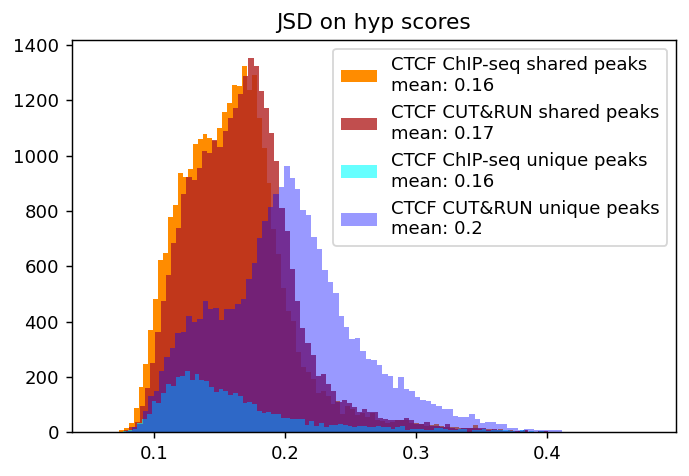

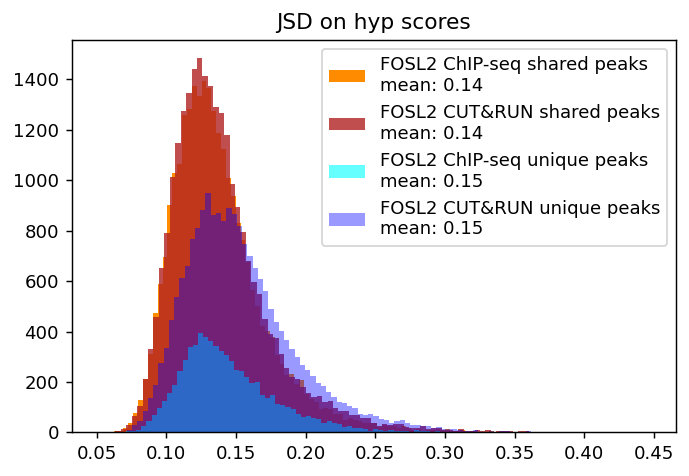

In [144]:
# plot distribution of correlations (across each CTCF subset)
for tf in tfs:
    fig = plt.figure()
    for i in range(4):
        mean = np.round(np.mean(jsd_hyp_scores[tf][subsets[i]]), 2)
        plt.hist(jsd_hyp_scores[tf][subsets[i]], bins=100, alpha=1-0.2*i, label=f'{tf.upper()} {pretty_subsets[i]}\nmean: {mean}',
                color=colors[i])
        means.loc[(tf.upper(), pretty_subsets[i]), 'Mean JSD on hyp scores'] = mean
    plt.legend()
    plt.title(metrics[7])

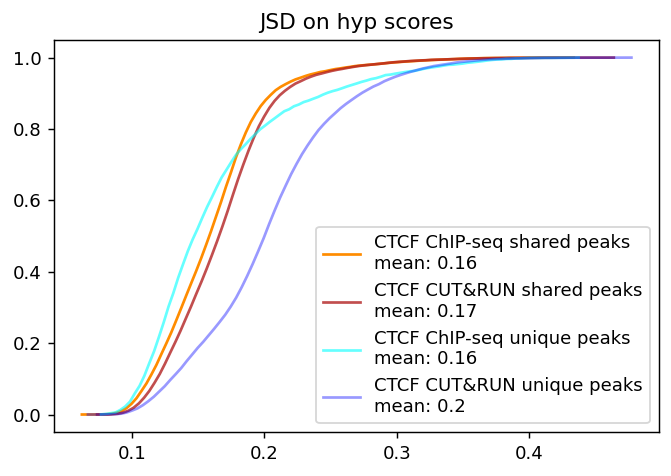

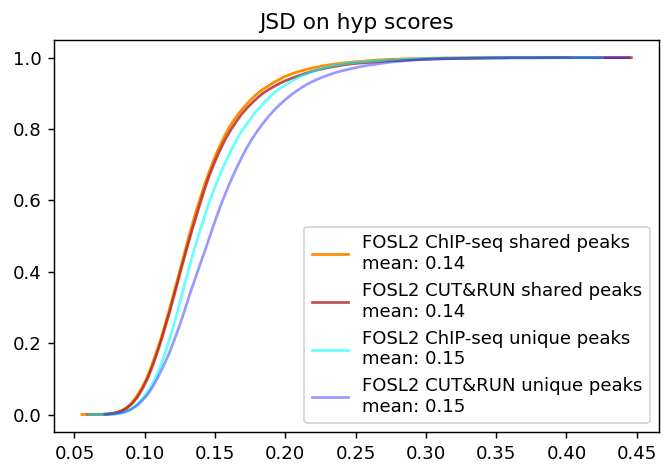

In [167]:
# plot cumulative distribution (CDF) of JSDs
for tf in tfs:
    fig = plt.figure()
    for i in range(4):
        mean = np.round(np.mean(jsd_hyp_scores[tf][subsets[i]]), 2)
        count, bins_count = np.histogram(jsd_hyp_scores[tf][subsets[i]], bins=100)
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        plt.plot(bins_count[1:], cdf, alpha=1-0.2*i, label=f'{tf.upper()} {pretty_subsets[i]}\nmean: {mean}', color=colors[i])
    plt.legend()
    plt.title(metrics[7])

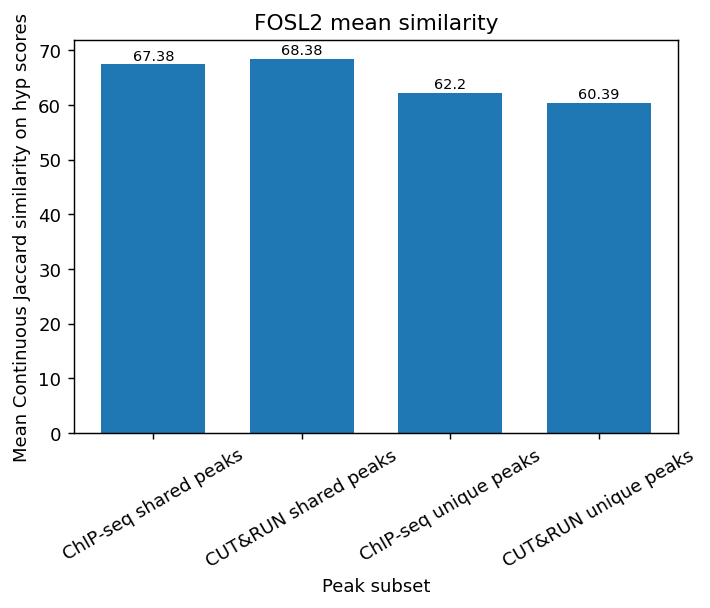

In [159]:
plot_metrics('FOSL2', 'Mean Continuous Jaccard similarity on hyp scores')

## Plot importance scores and predictions by subset

In [199]:
# load in preds
preds_dict = {}
preds_root = '/home/katie/bp_repo/reports/katie_notebooks/summer2022_analysis/preds_by_subset_jul16/'

# auxiliary dictionaries tragically necessary because im just that good at keeping naming consistent
convert_models = {'chipseq' : 'chip-seq_model', 'cutnrun' : 'cutnrun_model'}
convert_subsets = {'chip_shared' : 'shared_chip_loader', 'cut_shared' : 'shared_cut_loader', 
                   'chip_unique' : 'unique_chip_loader', 'cut_unique' : 'unique_cut_loader'}

for tf in tfs:
    preds_dict[tf] = {}
    for model in models:
        preds_dict[tf][model] = {}
        for subset in subsets:
            preds_dict[tf][model][subset] = {}
            true_profs, pred_profs, coords = import_profiles(f'{preds_root}{tf.upper()}/{convert_models[model]}/{convert_subsets[subset]}.preds')
            
            # n.b. pred_profs are a probability distribution summing to 1 (across each strand)

            # because of reverse complement augmentation, we need to:
            # 1. take the coords, make into a DataFrame, drop duplicates, and get the indexes of the unique coords
            # 2. use the unique indexes to subset true_profs and pred_profs into the unique profs (getting rid of rev comp)
            preds_dict[tf][model][subset]['coords_unique'] = pd.DataFrame(coords).drop_duplicates()
            indexes_unique = list(preds_dict[tf][model][subset]['coords_unique'].index)
            print(len(indexes_unique))
            preds_dict[tf][model][subset]['true_profs'] = true_profs[indexes_unique]
            preds_dict[tf][model][subset]['pred_profs'] = pred_profs[indexes_unique]

Importing predictions:   0%|          | 0/62 [00:00<?, ?it/s]

30821


Importing predictions:   0%|          | 0/60 [00:00<?, ?it/s]

29979


Importing predictions:   0%|          | 0/10 [00:00<?, ?it/s]

4980


Importing predictions:   0%|          | 0/49 [00:00<?, ?it/s]

24246


Importing predictions:   0%|          | 0/62 [00:00<?, ?it/s]

30821


Importing predictions:   0%|          | 0/60 [00:00<?, ?it/s]

29979


Importing predictions:   0%|          | 0/10 [00:00<?, ?it/s]

4980


Importing predictions:   0%|          | 0/49 [00:00<?, ?it/s]

24246


Importing predictions:   0%|          | 0/54 [00:00<?, ?it/s]

26508


Importing predictions:   0%|          | 0/51 [00:00<?, ?it/s]

25420


Importing predictions:   0%|          | 0/14 [00:00<?, ?it/s]

6960


Importing predictions:   0%|          | 0/41 [00:00<?, ?it/s]

20169


Importing predictions:   0%|          | 0/54 [00:00<?, ?it/s]

26508


Importing predictions:   0%|          | 0/51 [00:00<?, ?it/s]

25420


Importing predictions:   0%|          | 0/14 [00:00<?, ?it/s]

6960


Importing predictions:   0%|          | 0/41 [00:00<?, ?it/s]

20169


In [186]:
# plotting functions

def plot(profs, title):
    fig, ax = plt.subplots(1, figsize=(8, 1))

    ax.plot(profs[0,:,0], color="royalblue")
    ax.plot(-profs[0,:,1], color="goldenrod")
    plt.title(title)
    
def plot_examples_from_dict(preds_dict, prof_type='pred_profs', num_examples=3, imp_scores=True, custom_indexes=None):
    ''' preds_dict must be nested by tf -> model -> peak subset; in deepest tier, each key must map to a dictionary with the following format:
        `true_profs` : true profiles
        `pred_profs` : predicted profiles (probably a probability distribution but doesn't have to be)
        + other optional stuff
        
        will plot 3 examples by default using inds randomly generated 
        
        true_profs : specify if you want to plot true profs or, if not, pred profs
        num_examples : number of examples to plot (default is 2)
        imp_score : whether or not to also plot the importance scores associated with each peak (default True)
        custom_indexes : dict (with same keys used to access profs) with custom indexes (e.g. where jsds are very good/bad/etc.)
    '''
    assert prof_type in ['true_profs', 'pred_profs']
    rng = np.random.default_rng(seed=672022)
    
    for tf in tfs:
        for subset in subsets:
            inds = rng.integers(0, len(preds_dict[tf]['chipseq'][subset][prof_type]), 3) if custom_indexes is None \
                                                else custom_indexes[tf][subset]
            for ind in inds:
                print(ind)
                plot(preds_dict[tf]['chipseq'][subset][prof_type][ind], title=f'{prof_type} #{ind} from {tf.upper()} ChIP-seq model on {subset} peaks')
                if imp_scores:
                    plot_weights(scores_dict['act_scores'][tf]['chipseq'][subset][ind][100:300], subticks_frequency=100)  # plot middle 200 scores
                plot(preds_dict[tf]['cutnrun'][subset][prof_type][ind], title=f'{prof_type} #{ind} from {tf.upper()} CUT&RUN model on {subset} peaks')
                if imp_scores:
                    plot_weights(scores_dict['act_scores'][tf]['cutnrun'][subset][ind][100:300], subticks_frequency=100)  # plot middle 200 scores

In [194]:
custom_indexes

{'ctcf': {'chip_shared': array([30295, 29211, 24729,    71,    22,    46]),
  'cut_shared': array([    4,    58,     2, 23193, 29951, 29830]),
  'chip_unique': array([3307, 3262, 3476,    1,    2,    4]),
  'cut_unique': array([  11,   46,   69, 5718, 2300,   48])},
 'fosl2': {'chip_shared': array([ 7638, 21182, 17061,    15,    25,    12]),
  'cut_shared': array([ 4470,  3972,  2778, 18761, 22838, 23283]),
  'chip_unique': array([ 141, 6933, 2681,   39,    2,    1]),
  'cut_unique': array([   39,   206,  4153,  7158,   101, 16495])}}

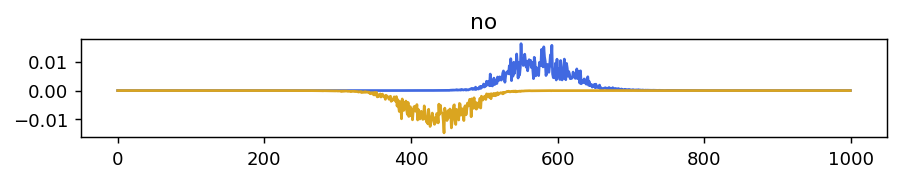

In [201]:
plot(preds_dict['ctcf']['chipseq']['chip_shared']['pred_profs'][22], title='no')

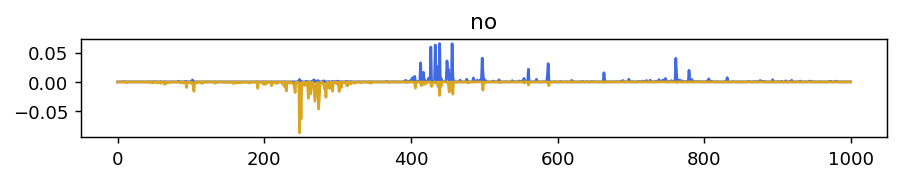

In [202]:
plot(preds_dict['ctcf']['cutnrun']['chip_shared']['pred_profs'][22], title='no')

In [216]:
jsds_dict = {}
for tf in tfs:
    jsds_dict[tf] = {}
    for subset in subsets:
        jsds_dict[tf][subset] = {'chipseq':{}, 'cutnrun':{}}
        # check cutnrun vs chipseq models
        
        jsds_dict[tf][subset]['chipseq'] = profile_jsd(preds_dict[tf]['chipseq'][subset]['true_profs'], 
                                                       preds_dict[tf]['chipseq'][subset]['pred_profs'],
       prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81, smooth_true_profs=False, smooth_pred_profs=False)
        
        jsds_dict[tf][subset]['cutnrun'] = profile_jsd(preds_dict[tf]['cutnrun'][subset]['true_profs'], 
                                                       preds_dict[tf]['cutnrun'][subset]['pred_profs'],
       prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81, smooth_true_profs=False, smooth_pred_profs=False)
        
        no_nans_inds = ~np.isnan(jsds_dict[tf][subset]['cutnrun'] - jsds_dict[tf][subset]['chipseq']).reshape(-1)
        jsds_dict[tf][subset]['cutnrun'] = jsds_dict[tf][subset]['cutnrun'][no_nans_inds]
        
        jsds_dict[tf][subset]['chipseq'] = jsds_dict[tf][subset]['chipseq'][no_nans_inds]
        
        preds_dict[tf]['chipseq'][subset]['true_profs'] = preds_dict[tf]['chipseq'][subset]['true_profs'][no_nans_inds]
        preds_dict[tf]['cutnrun'][subset]['true_profs'] = preds_dict[tf]['cutnrun'][subset]['true_profs'][no_nans_inds]
        preds_dict[tf]['chipseq'][subset]['pred_profs'] = preds_dict[tf]['chipseq'][subset]['pred_profs'][no_nans_inds]
        preds_dict[tf]['cutnrun'][subset]['pred_profs'] = preds_dict[tf]['cutnrun'][subset]['pred_profs'][no_nans_inds]

In [218]:
custom_indexes = {}
for tf in tfs:
    custom_indexes[tf] = {}
    for subset in subsets:
        cutnrun_minus_chipseq_jsd = (jsds_dict[tf][subset]['cutnrun'] - jsds_dict[tf][subset]['chipseq']).reshape(-1)
        custom_indexes[tf][subset] = np.concatenate((np.argpartition(cutnrun_minus_chipseq_jsd, 3)[:3],
            np.argpartition(cutnrun_minus_chipseq_jsd, -3)[-3:]))   # mins then maxes

In [ ]:
# ill think about how to do this but basically i need indexes where chipseq jsd is very high and cutnrun is very low, and vise versa
# what i currently have is wrong because it's just where their difference is maximized (good) but also where it's minimized 
   # (which might not be right, e.g. if the minimum is 0 this is where jsds agree)

30295


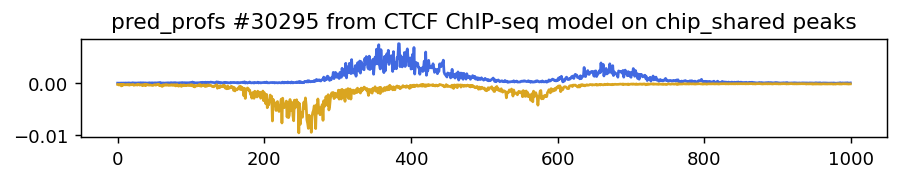

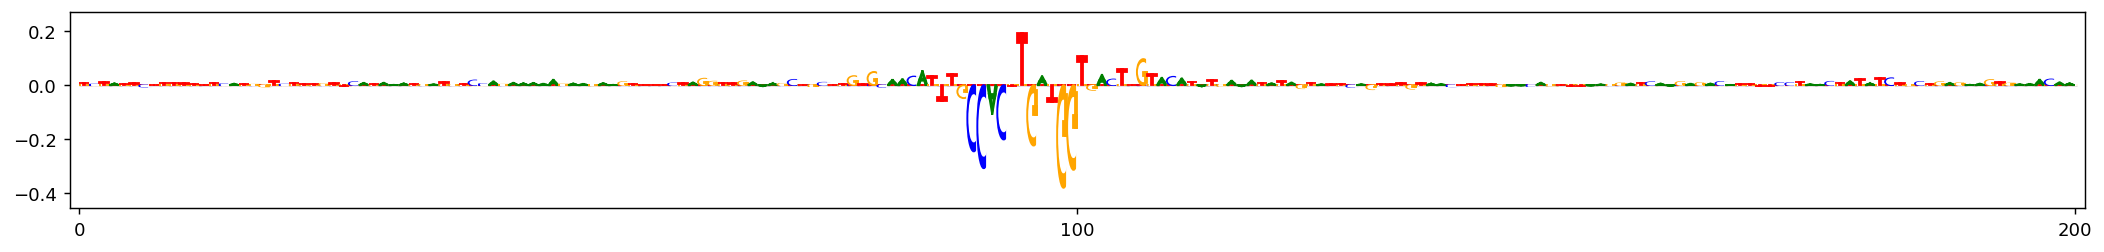

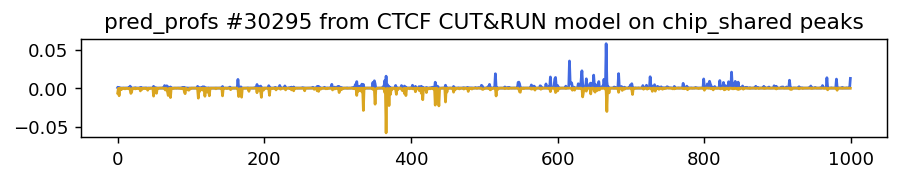

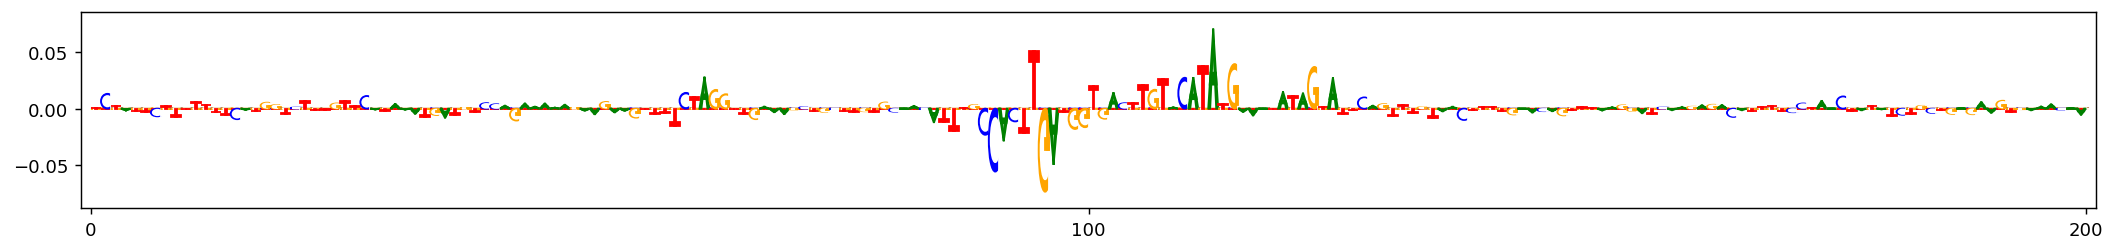

29211


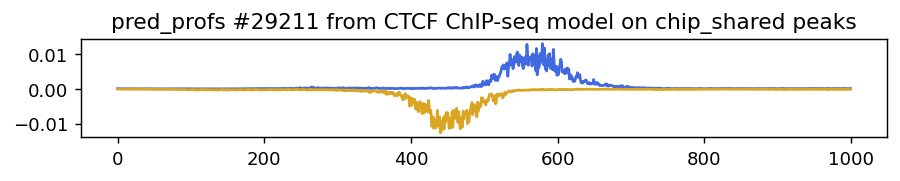

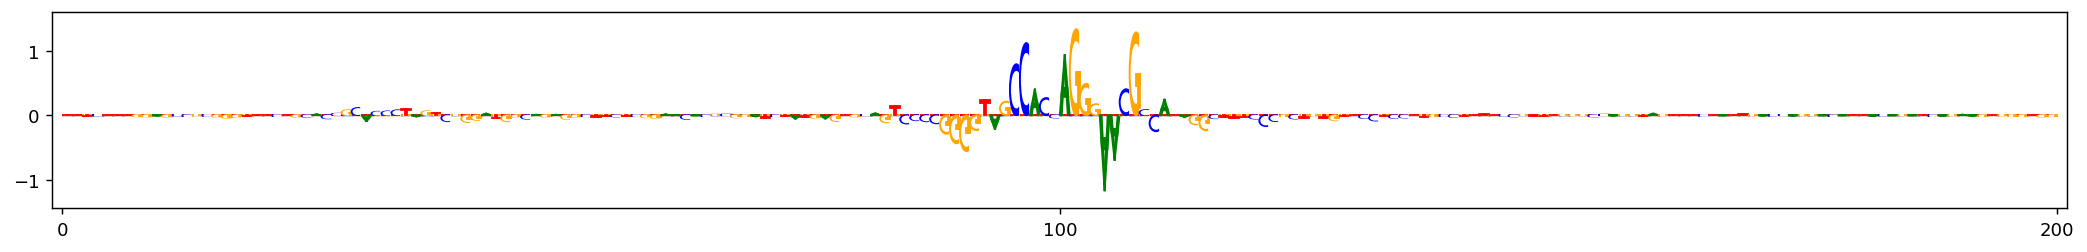

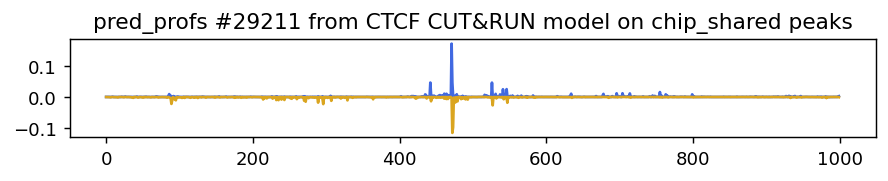

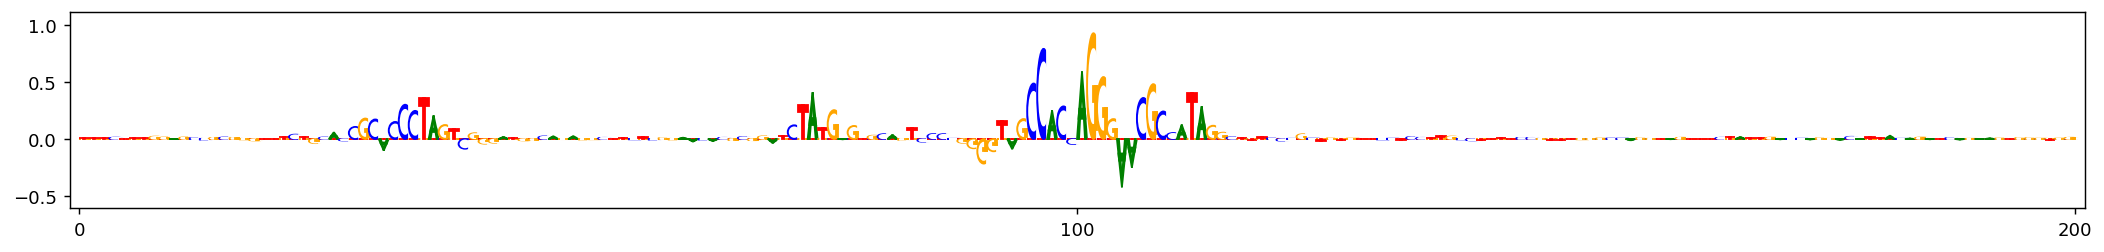

24729


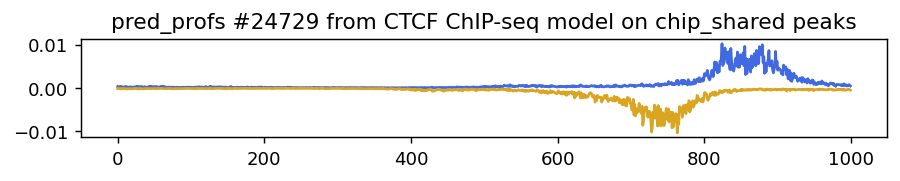

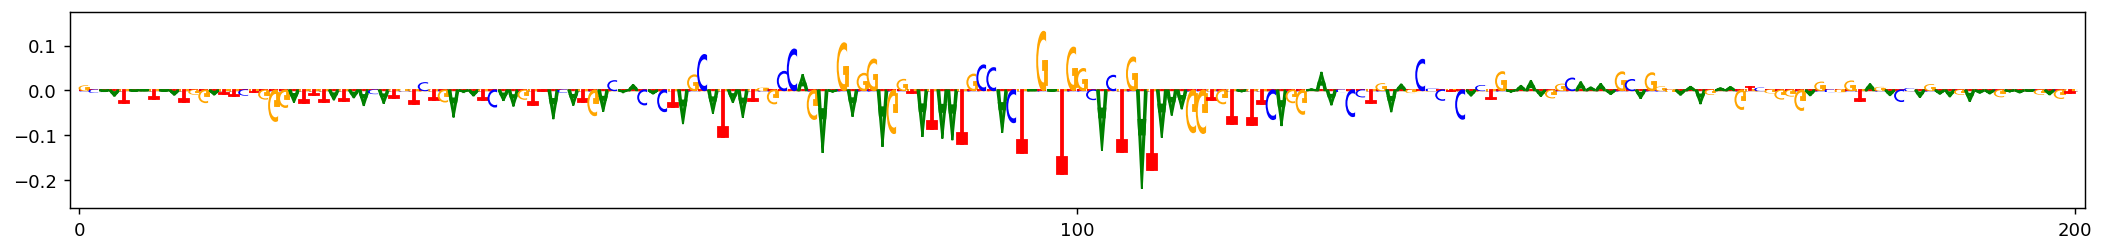

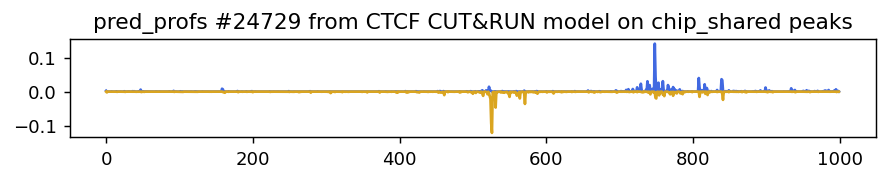

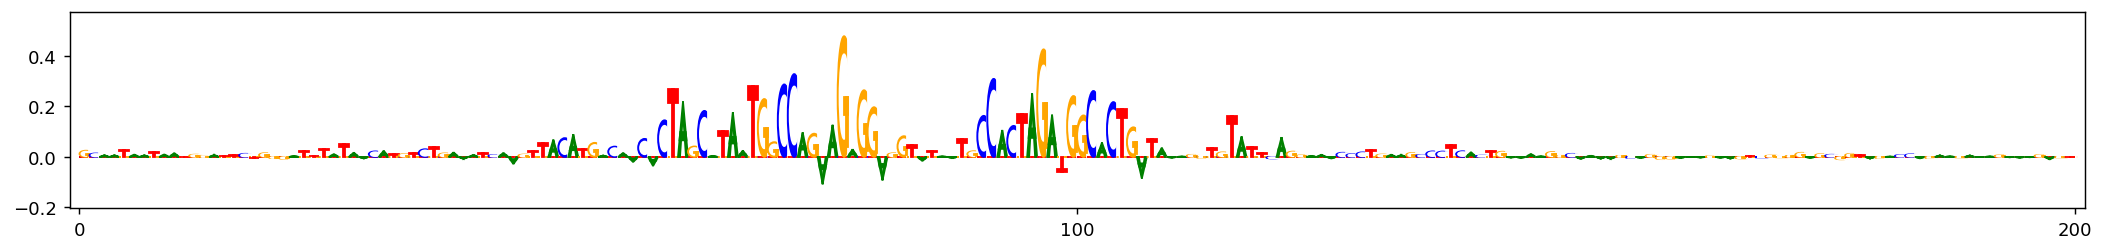

71


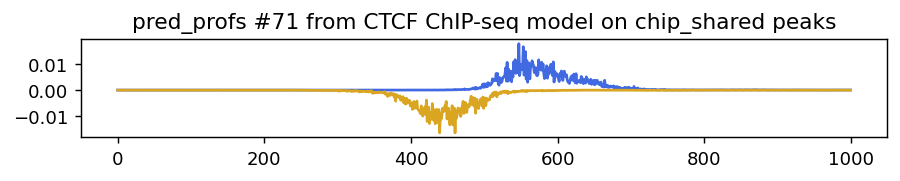

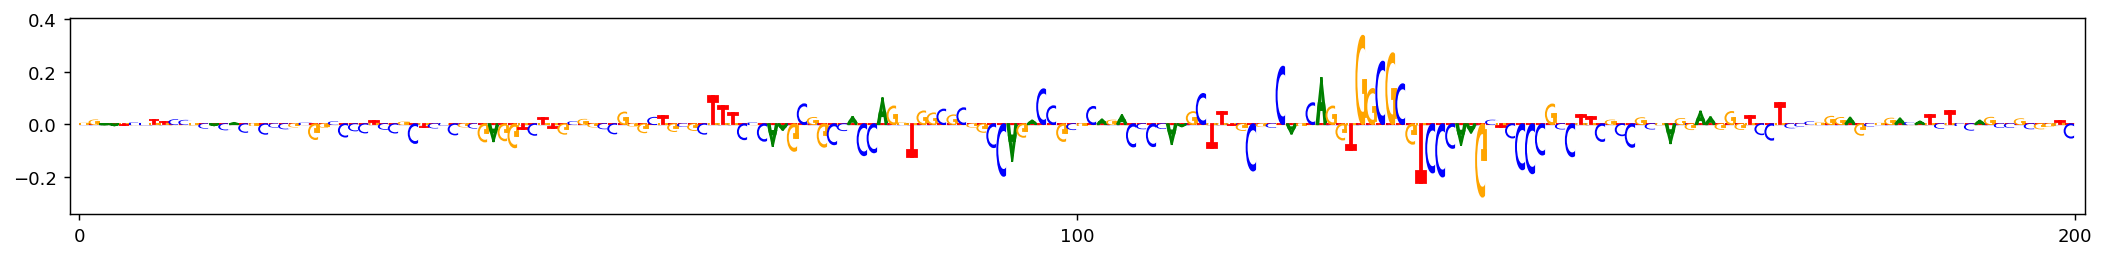

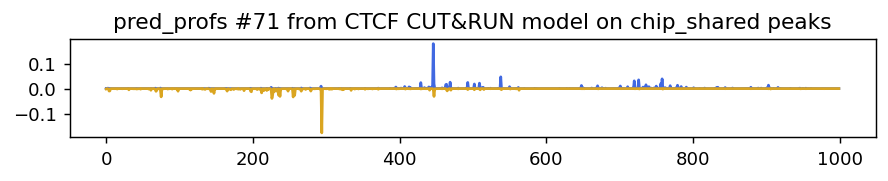

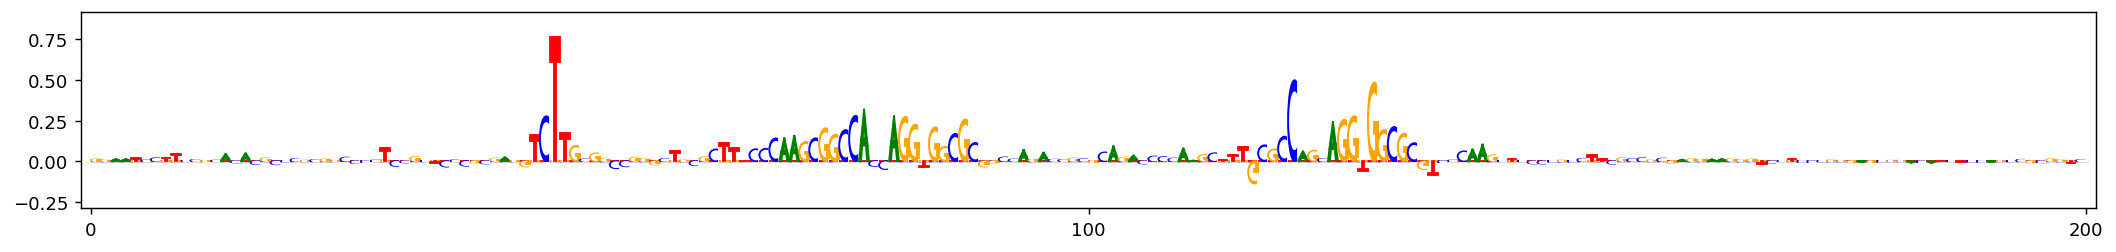

22


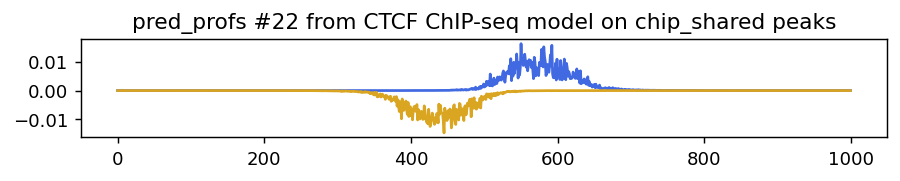

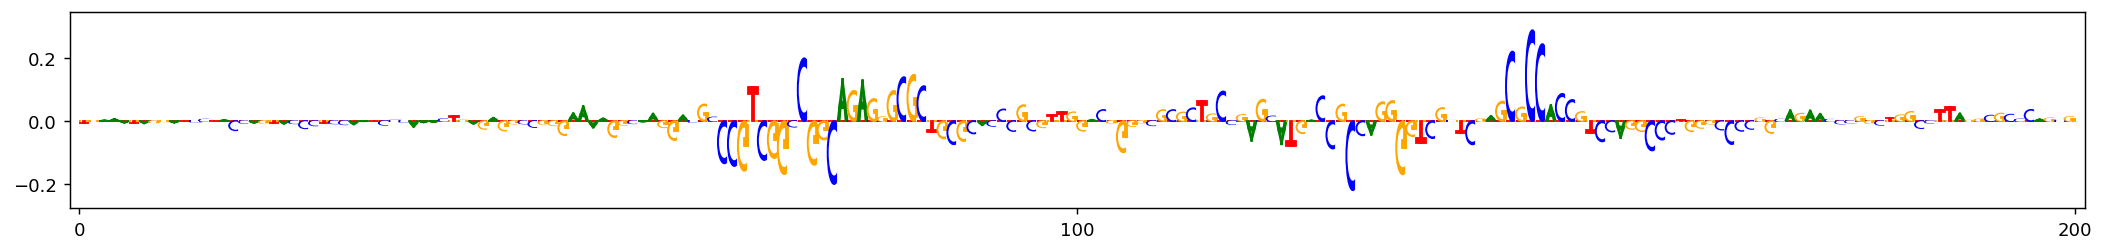

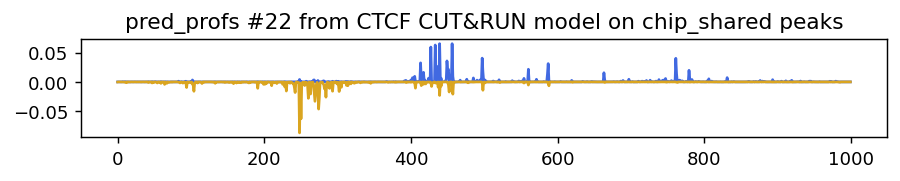

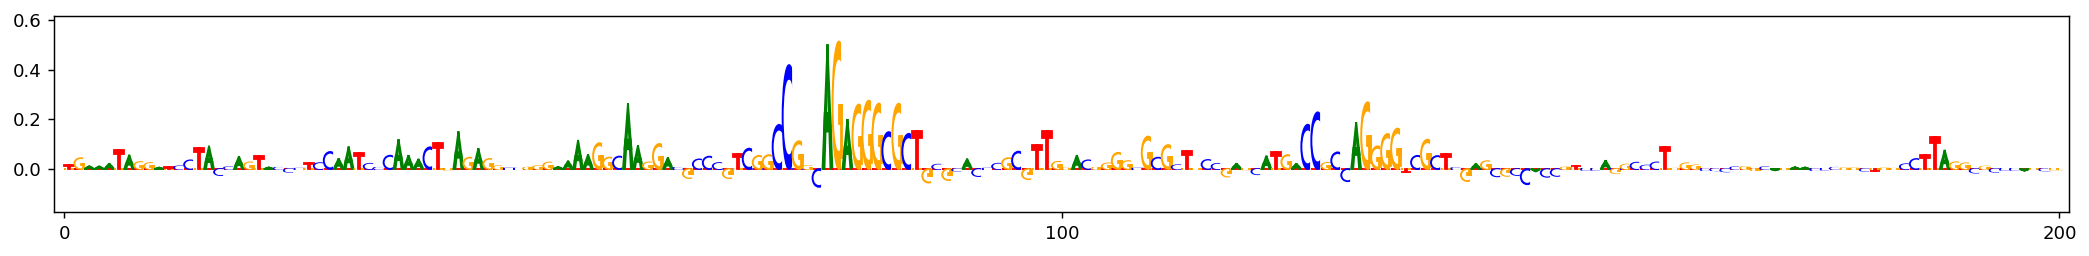

46


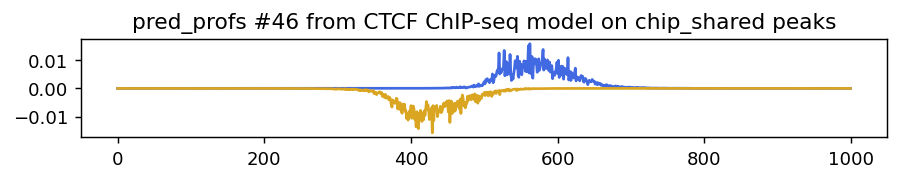

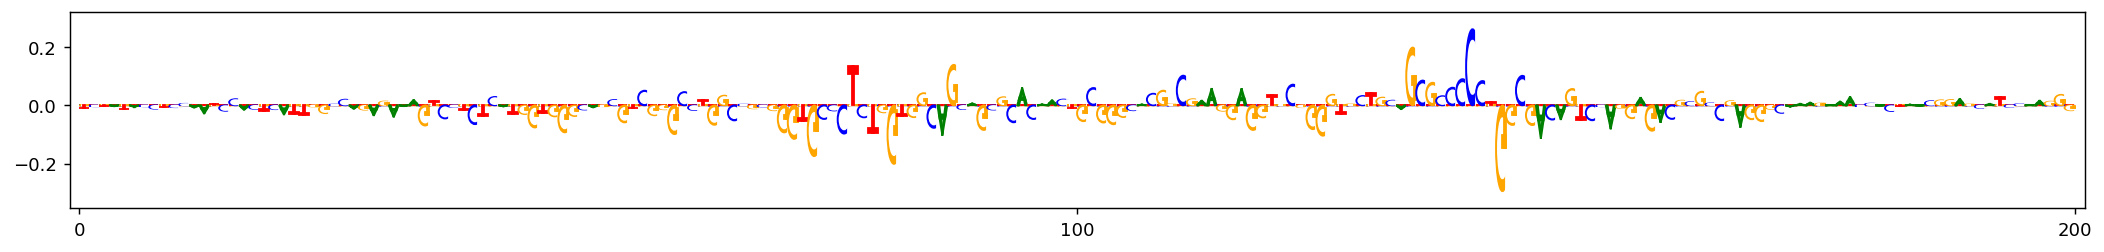

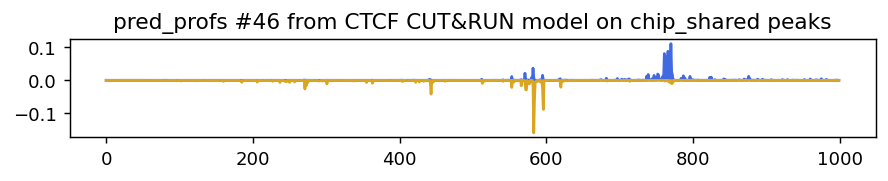

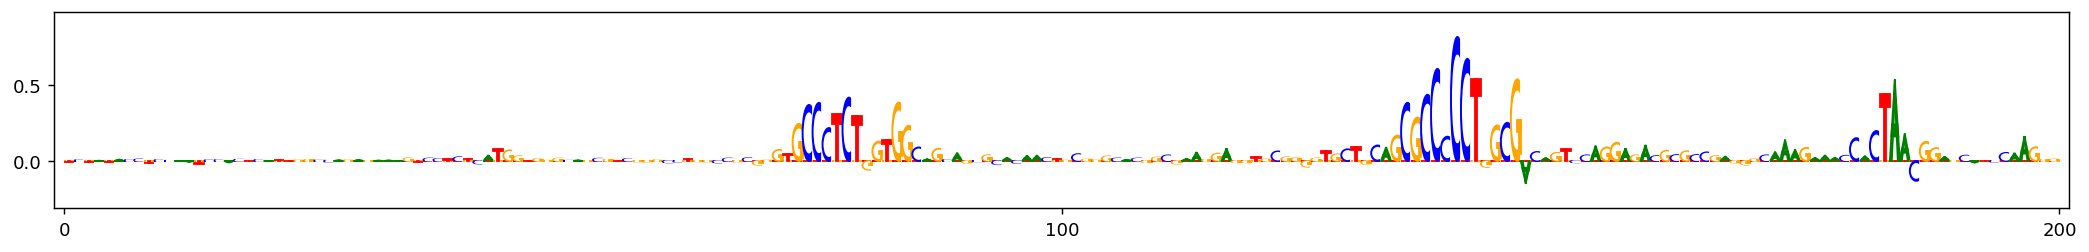

4


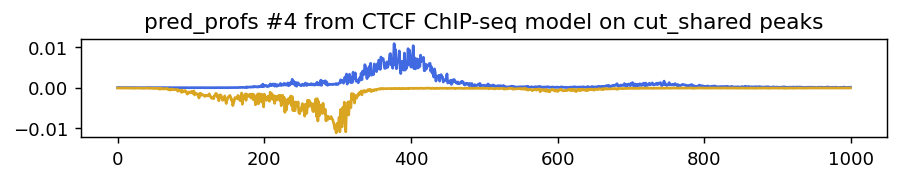

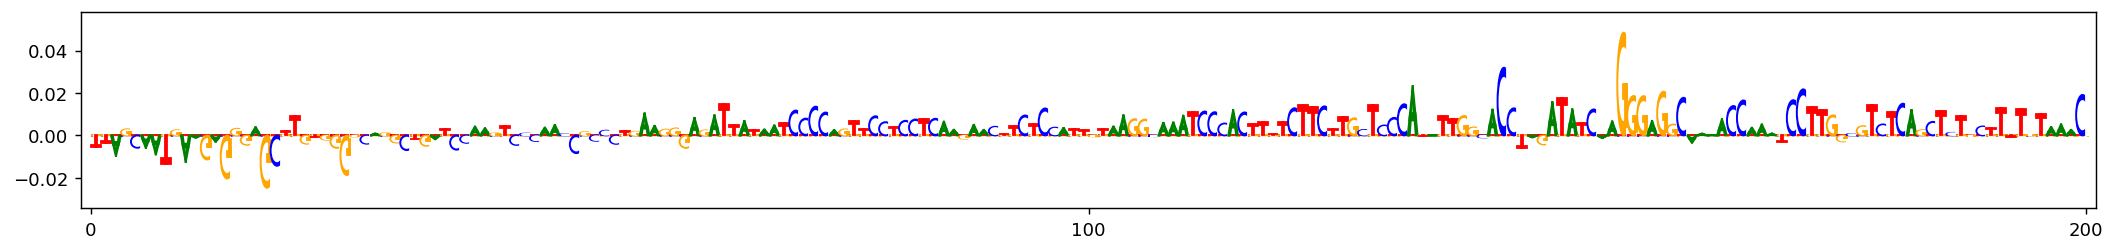

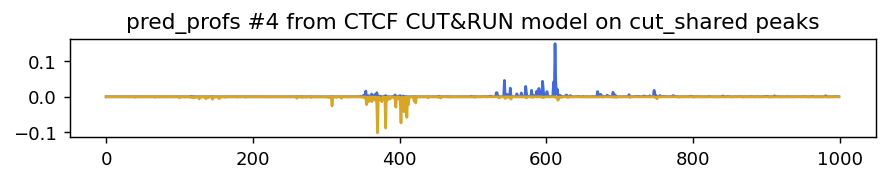

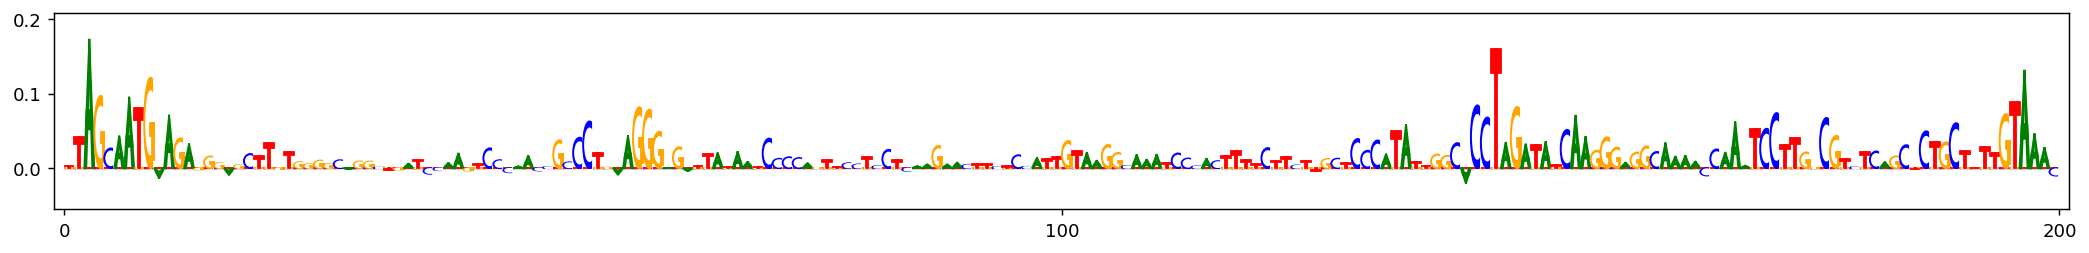

58


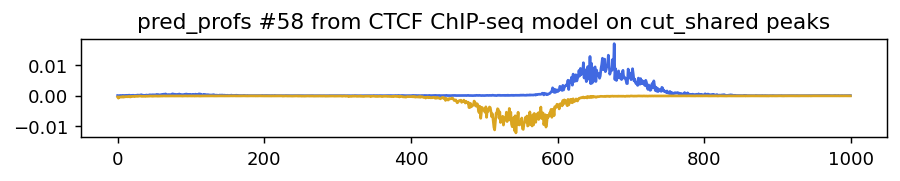

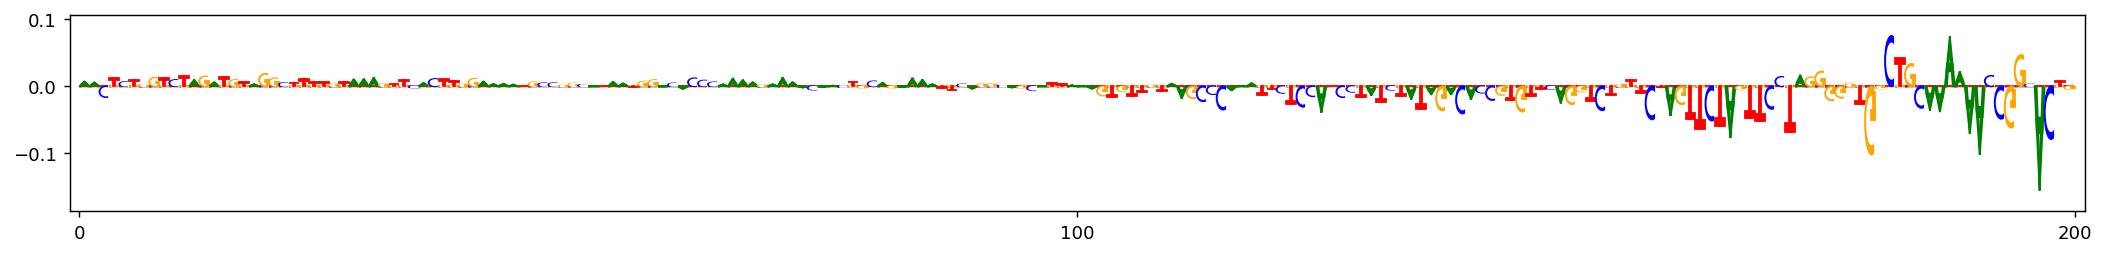

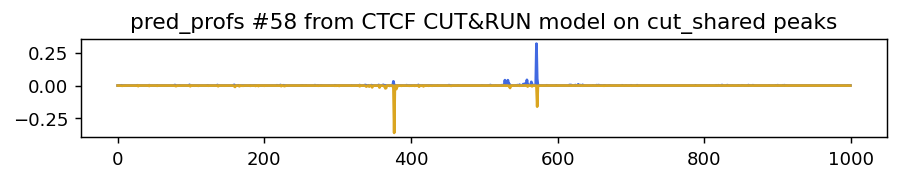

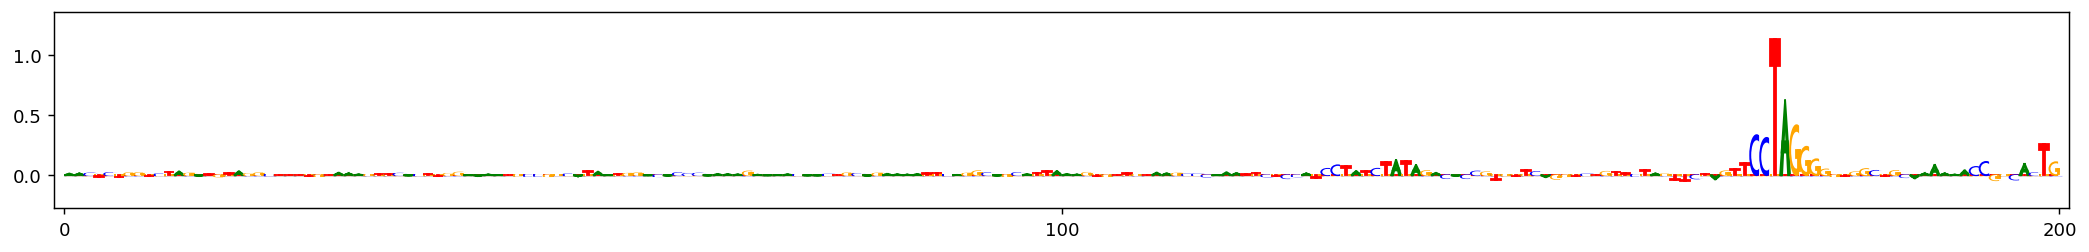

2


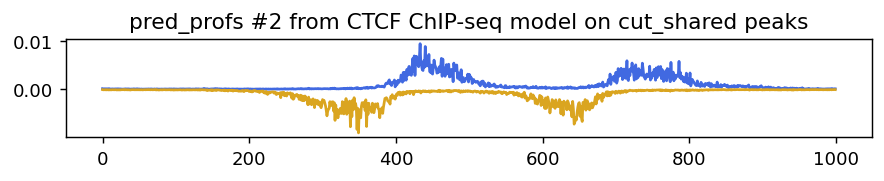

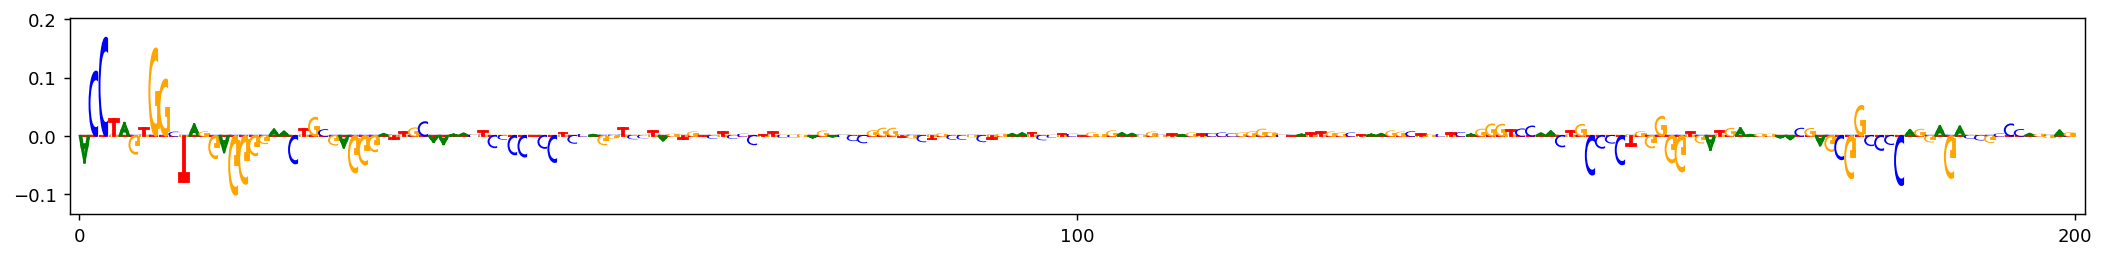

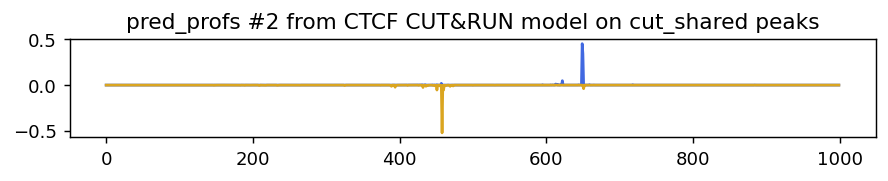

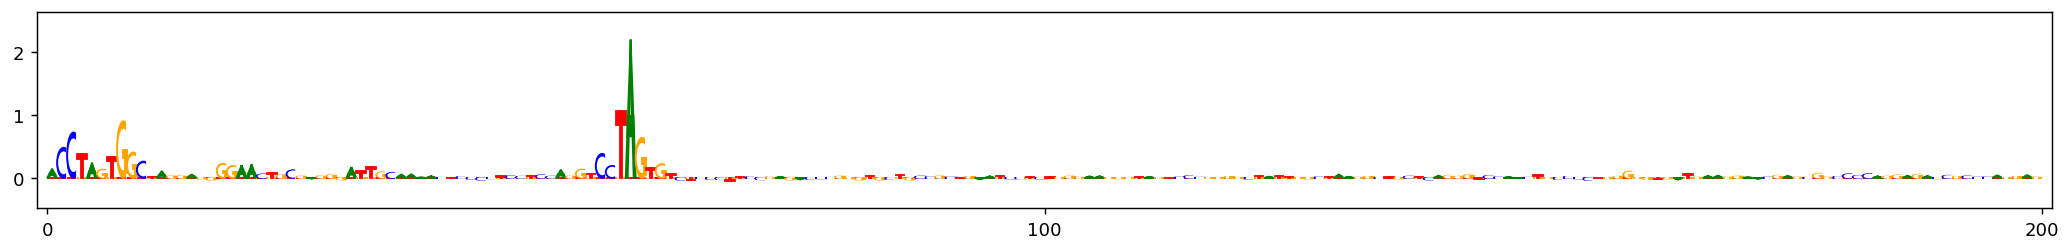

23193


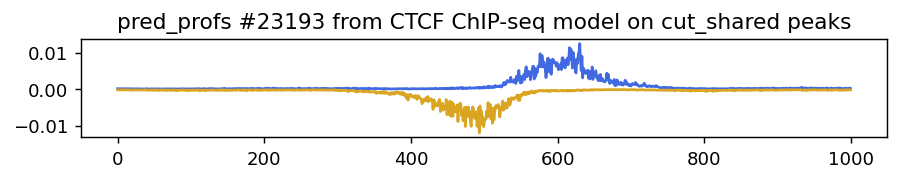

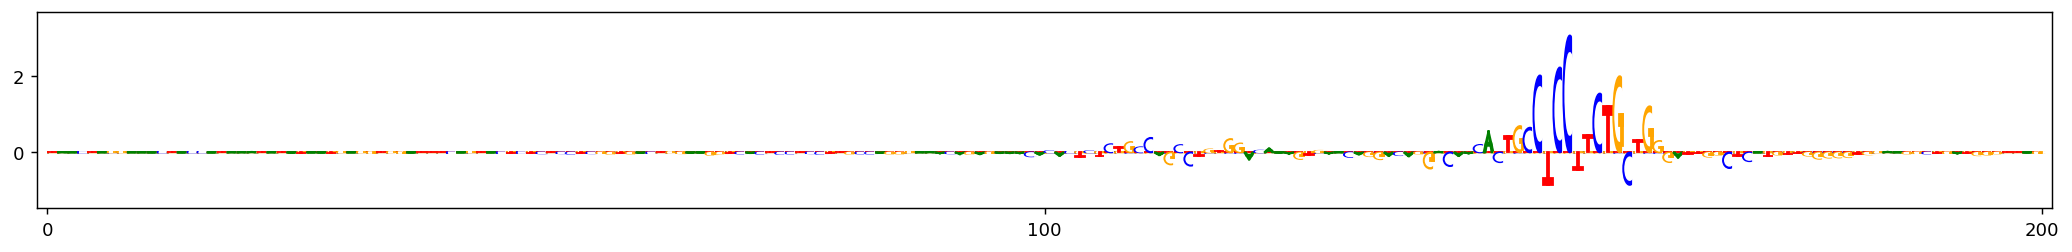

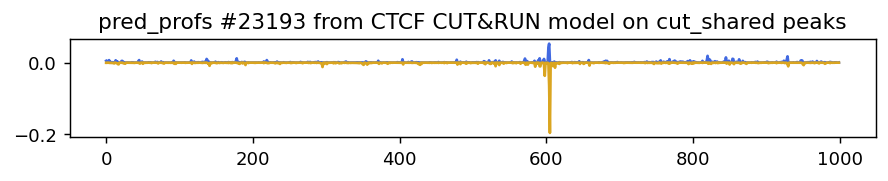

KeyboardInterrupt: 

In [220]:
plot_examples_from_dict(preds_dict, custom_indexes=custom_indexes)

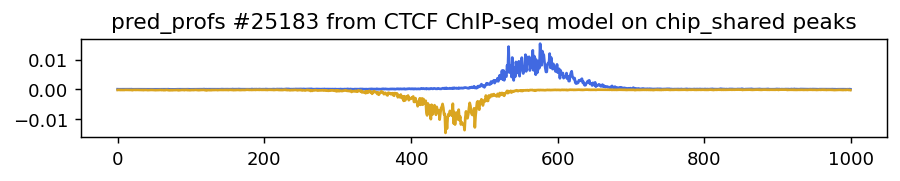

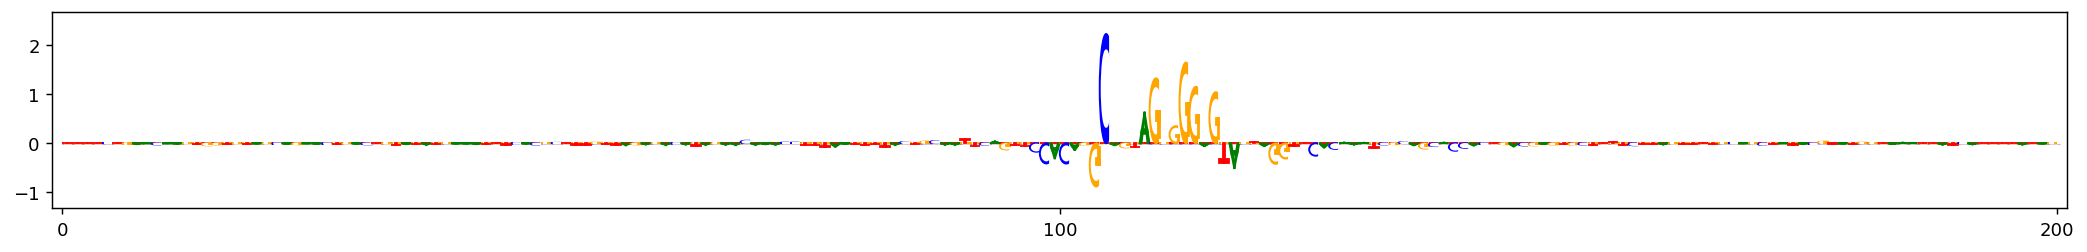

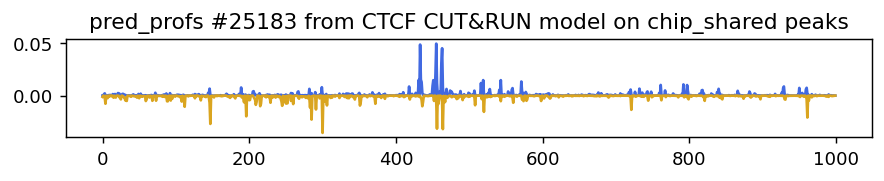

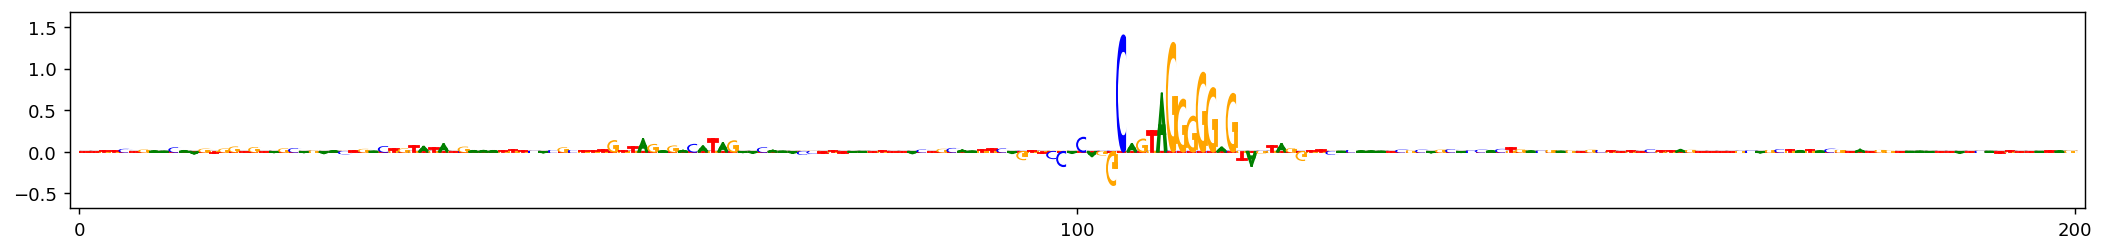

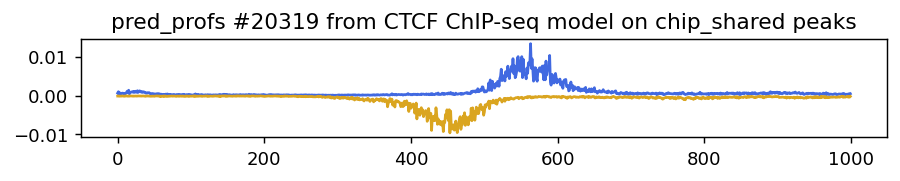

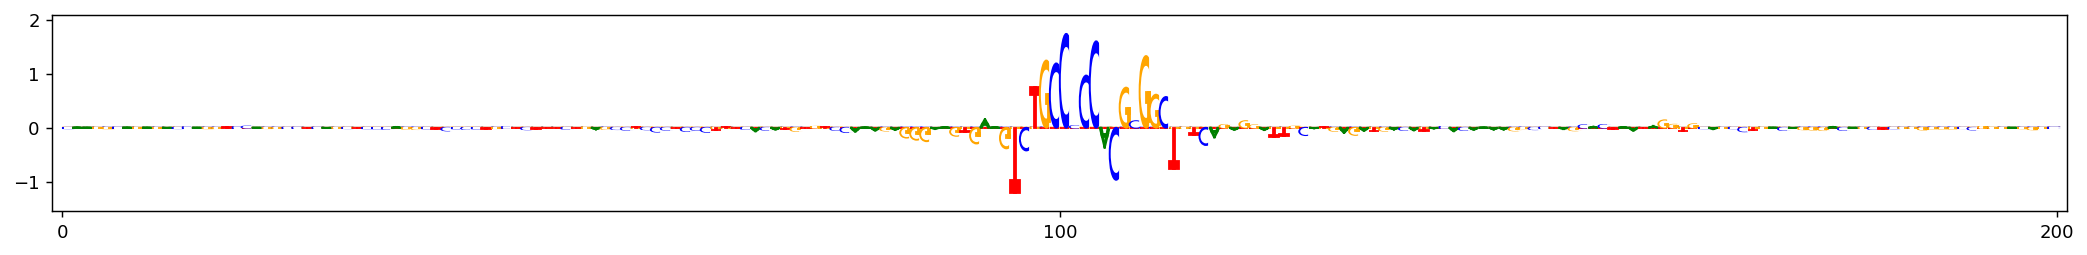

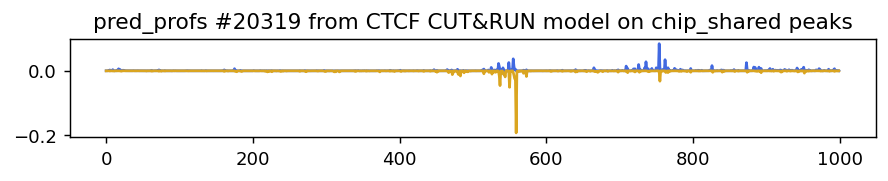

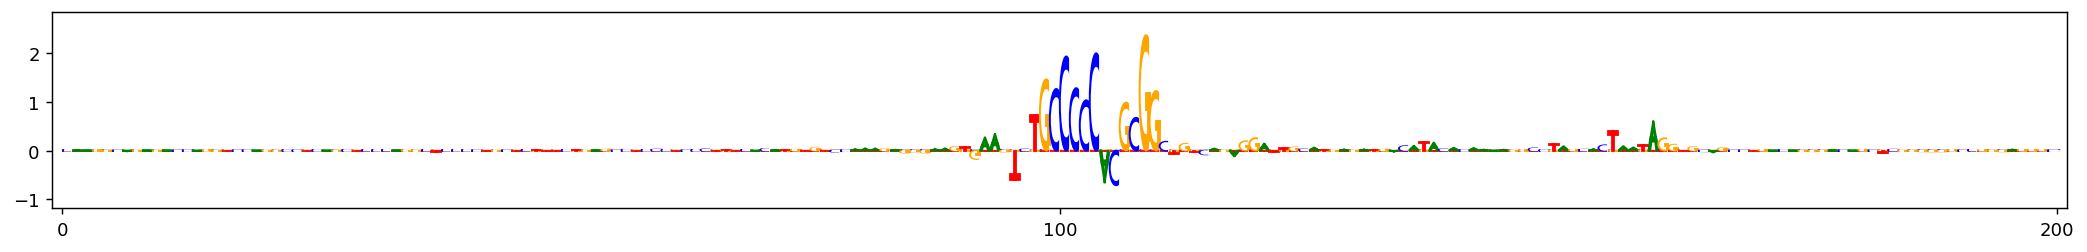

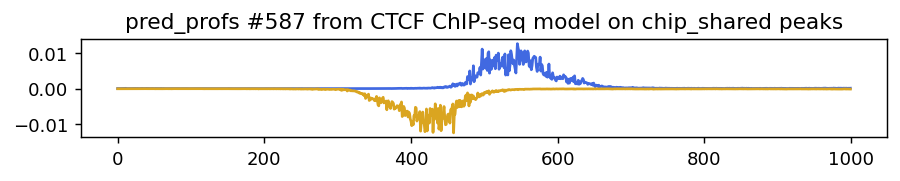

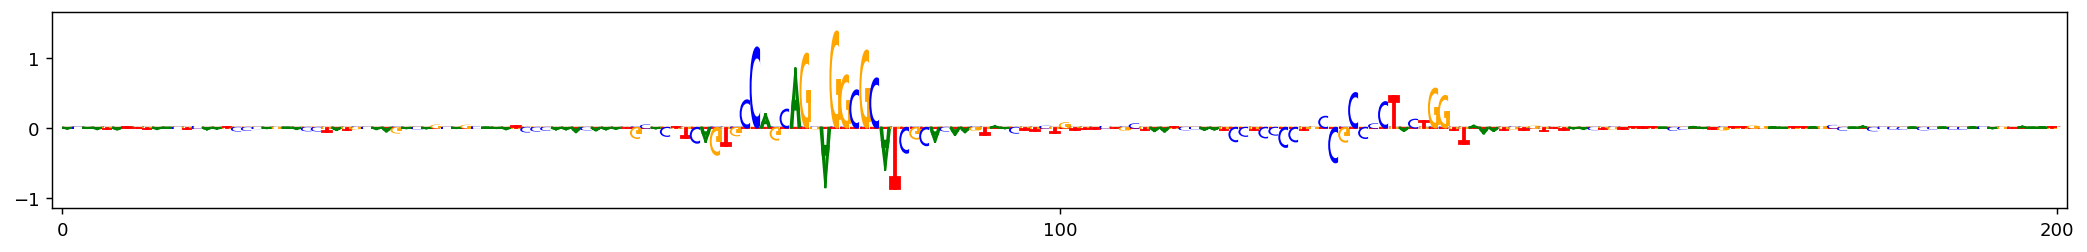

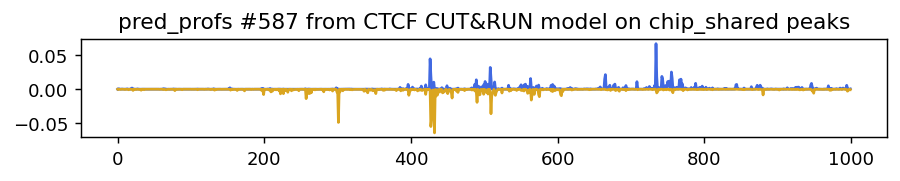

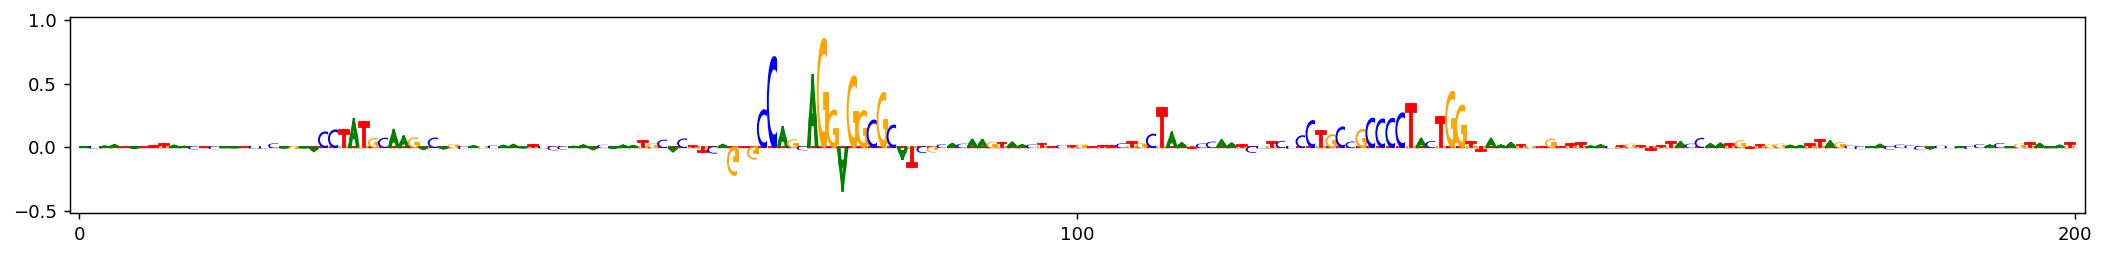

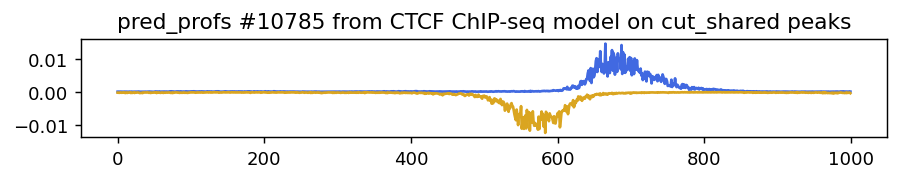

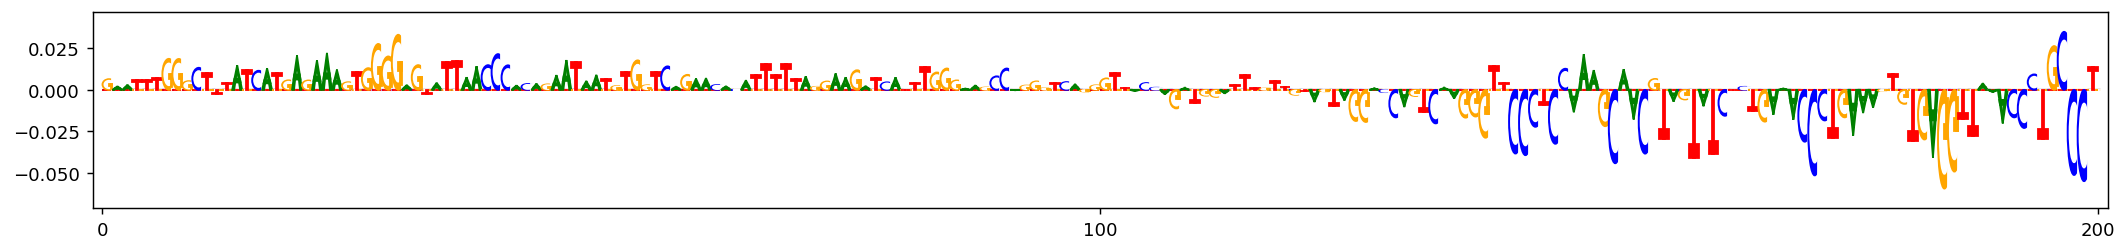

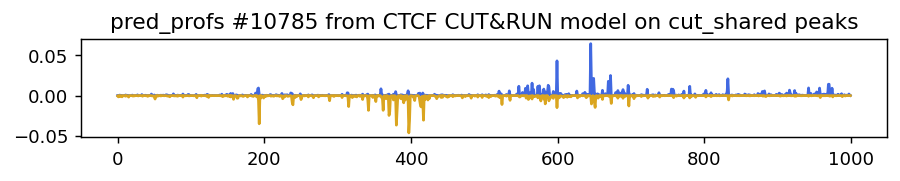

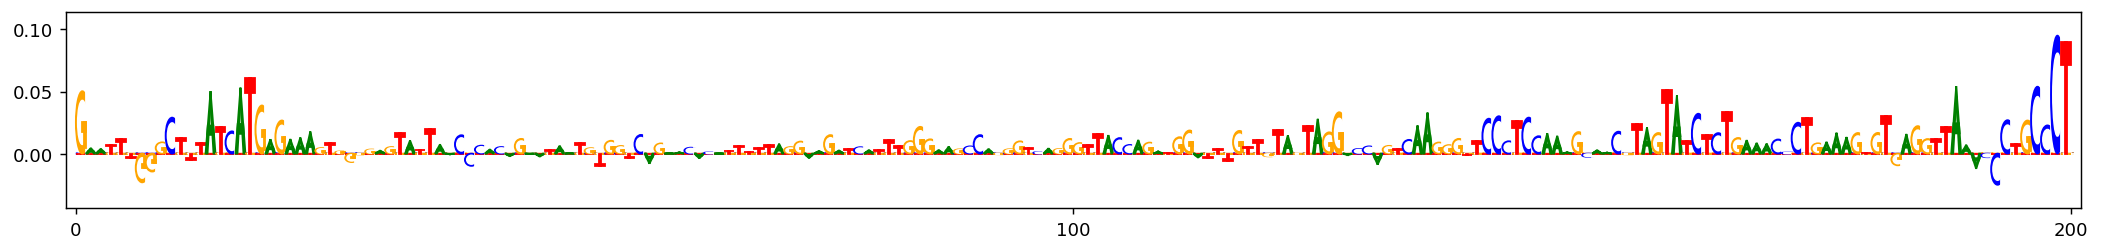

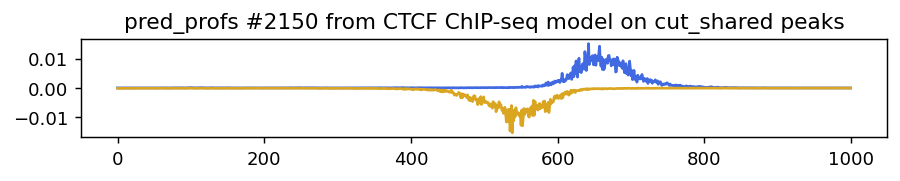

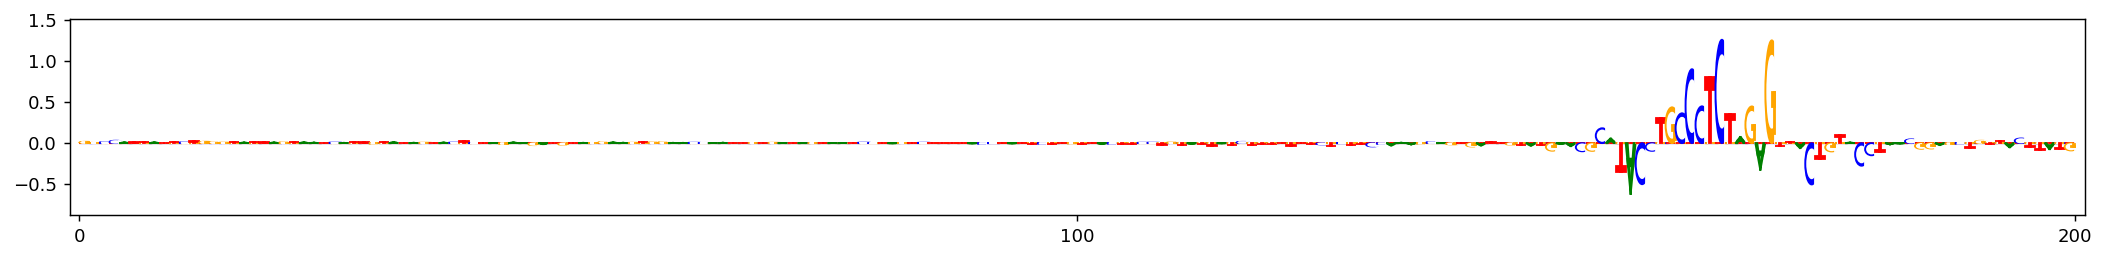

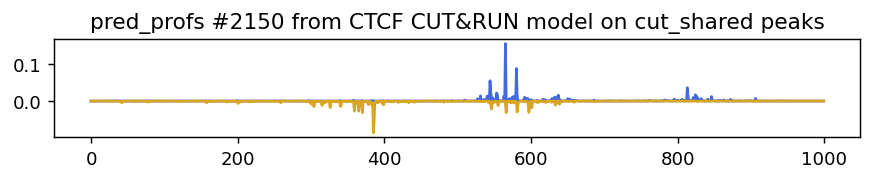

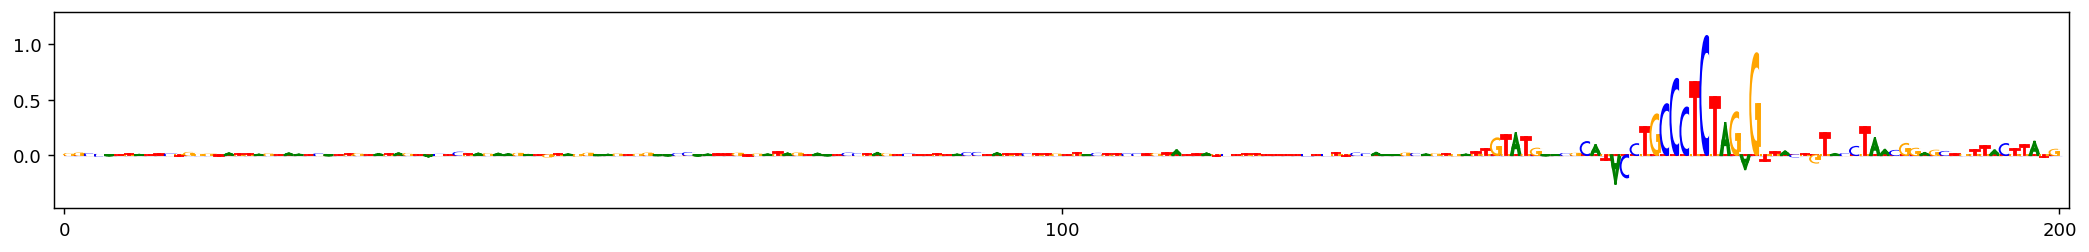

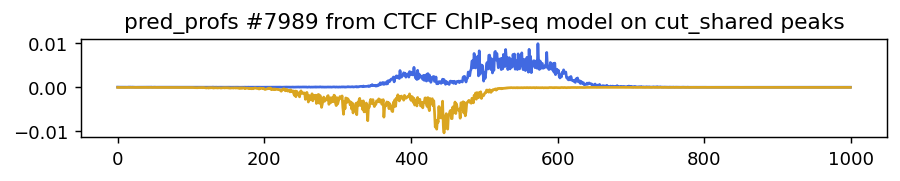

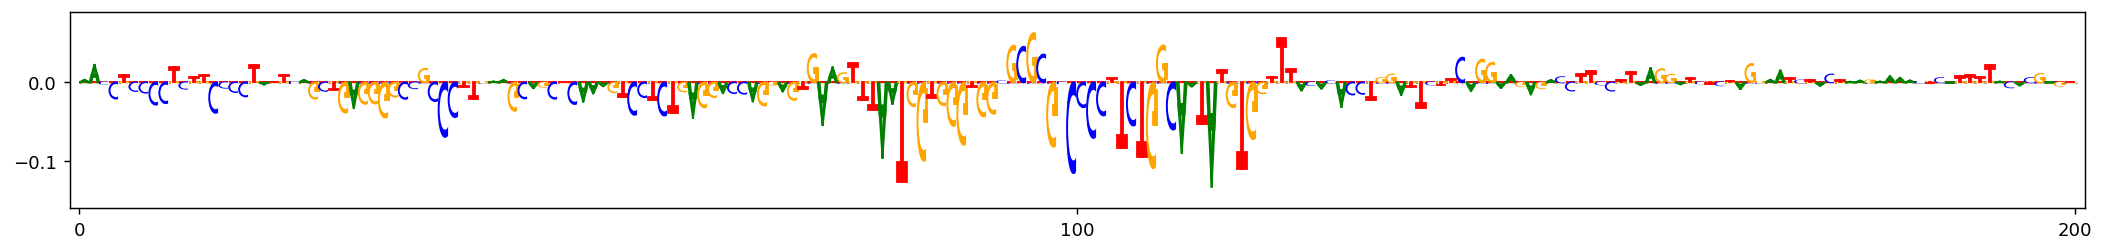

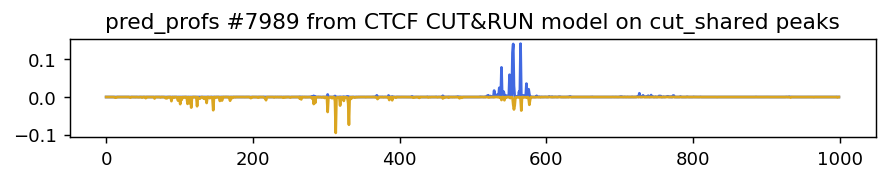

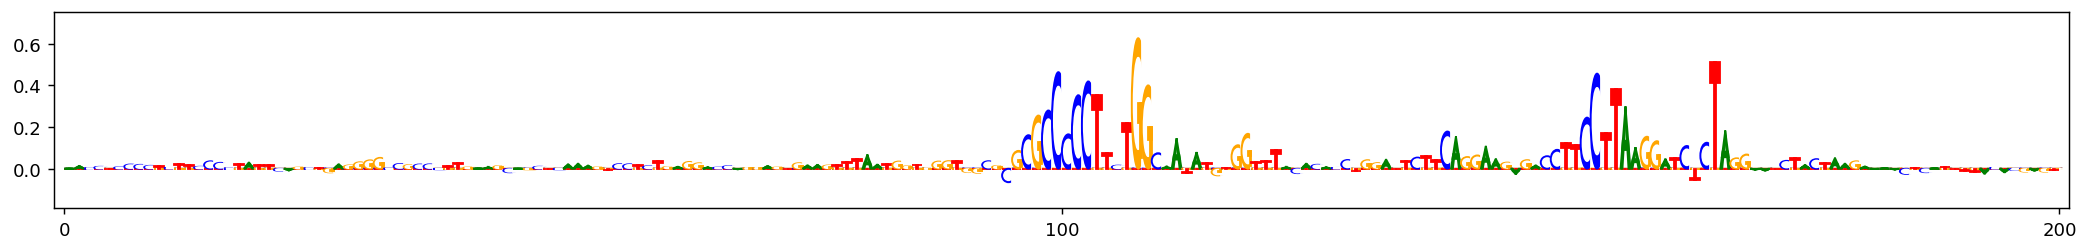

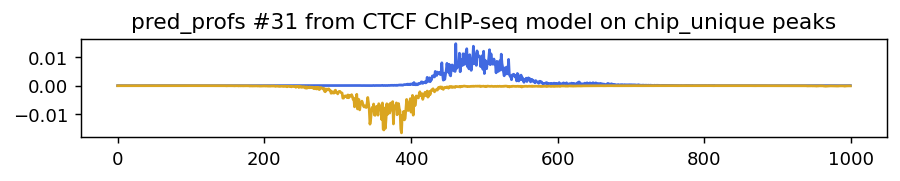

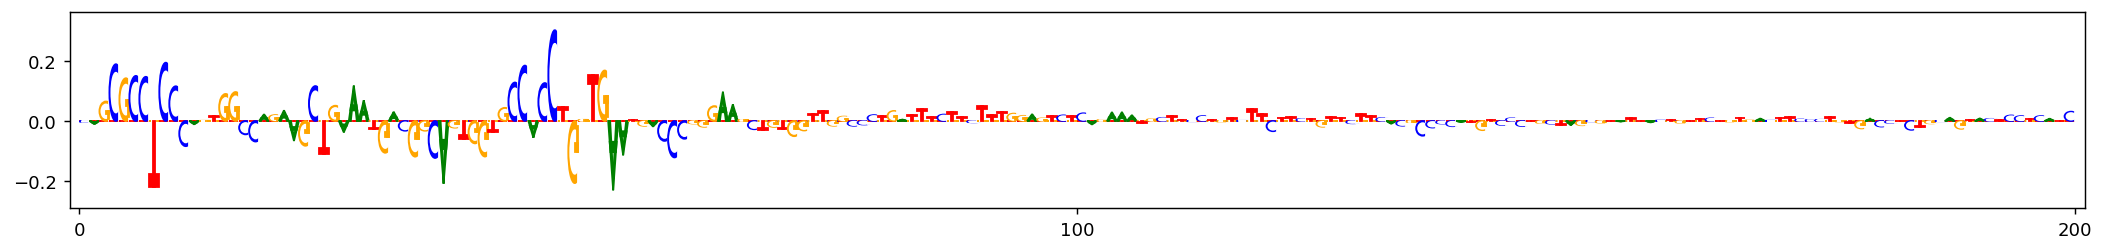

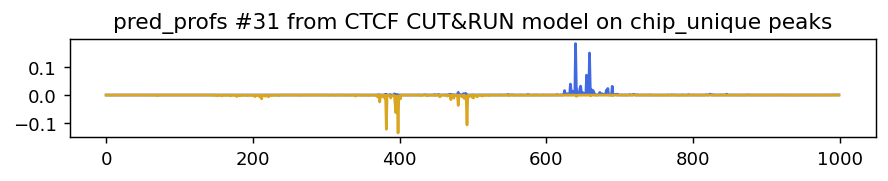

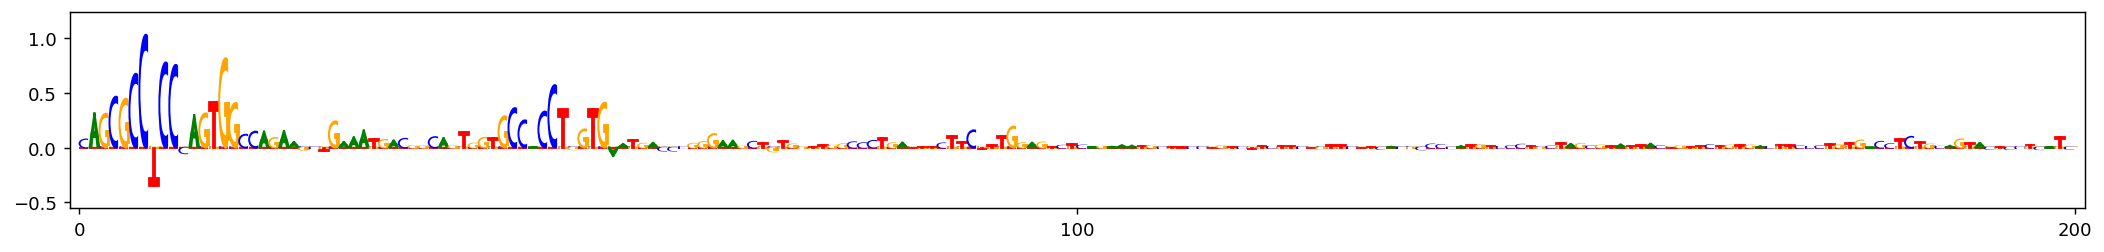

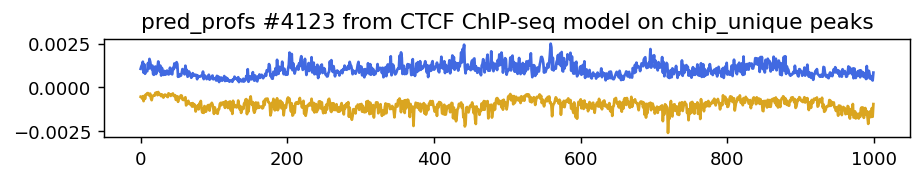

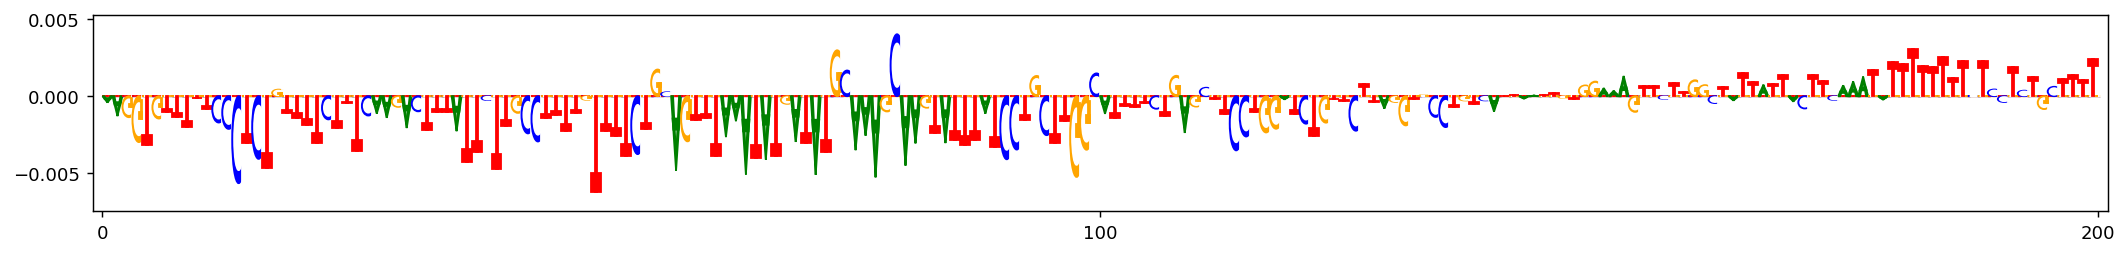

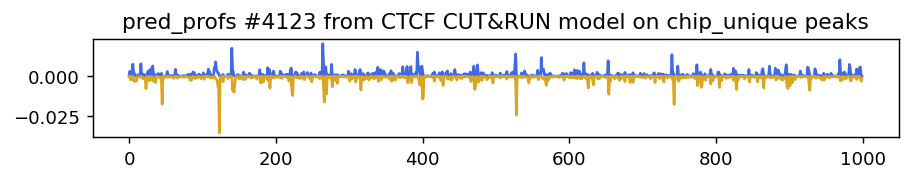

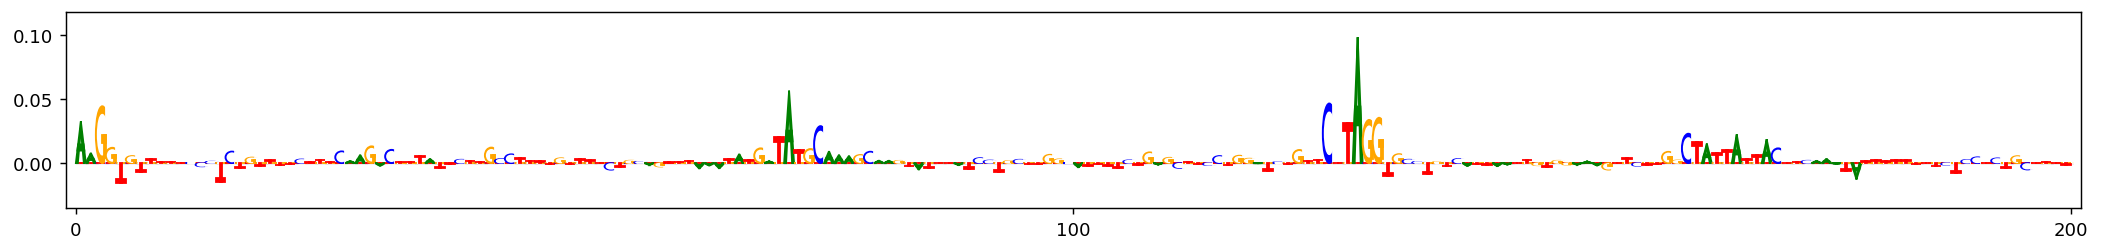

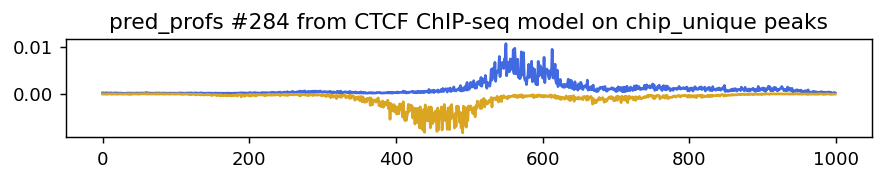

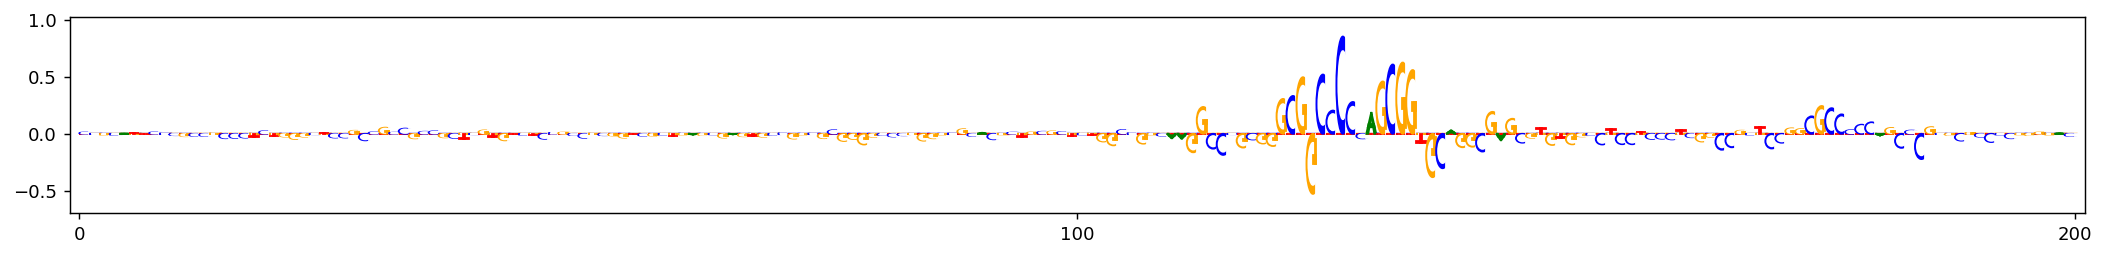

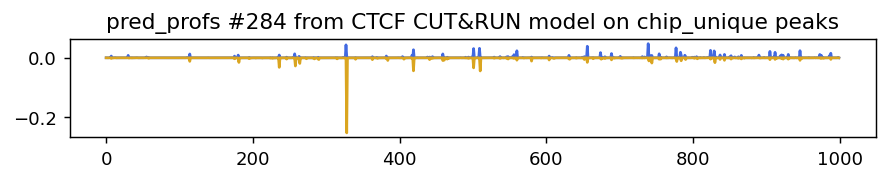

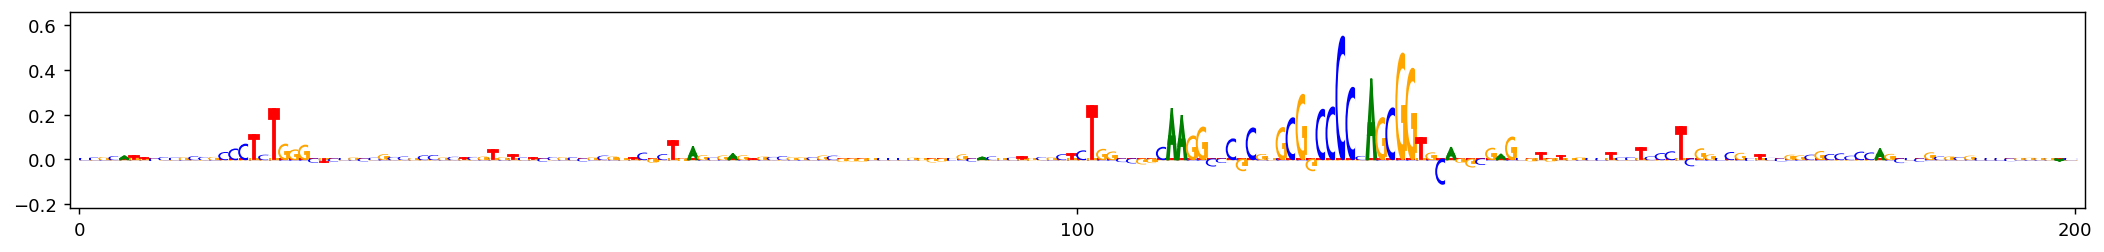

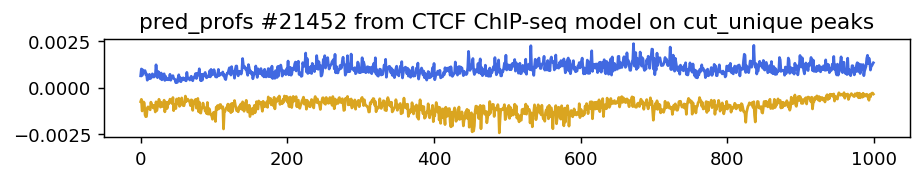

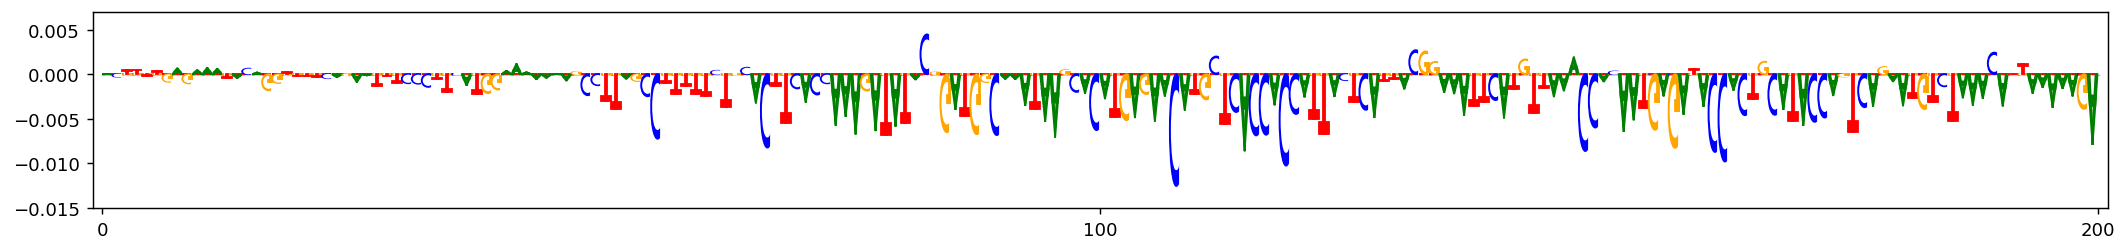

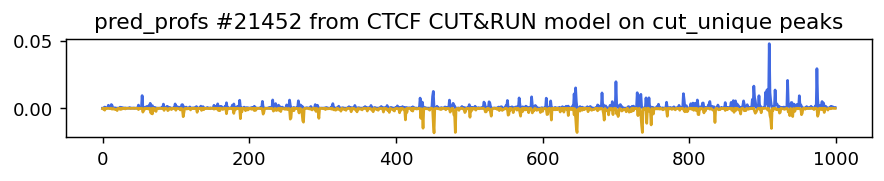

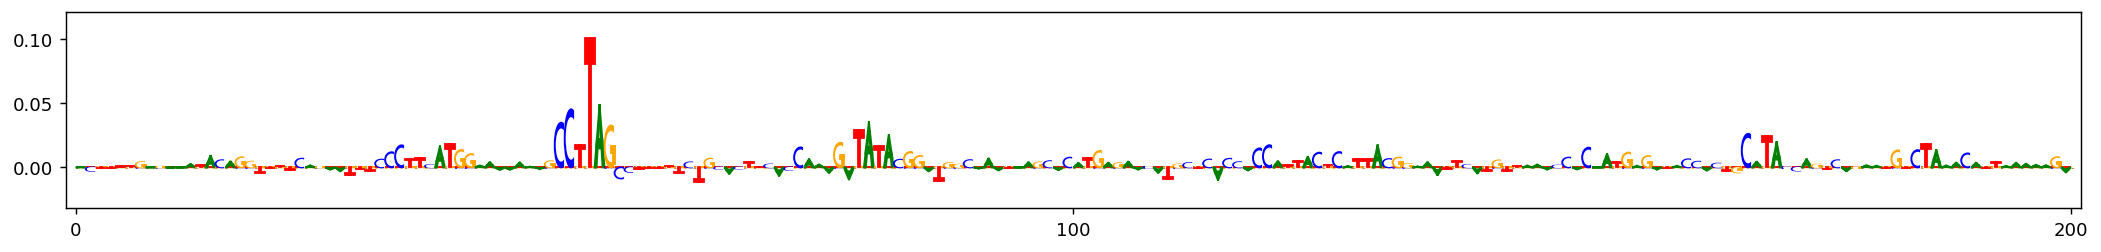

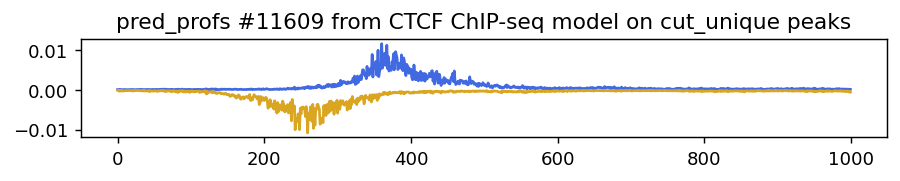

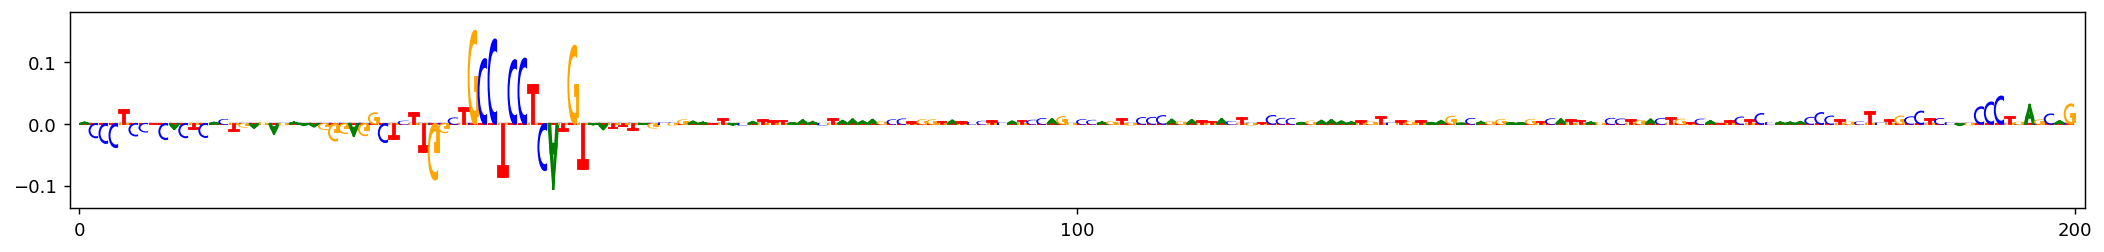

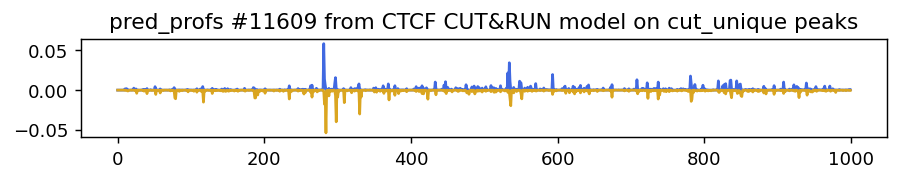

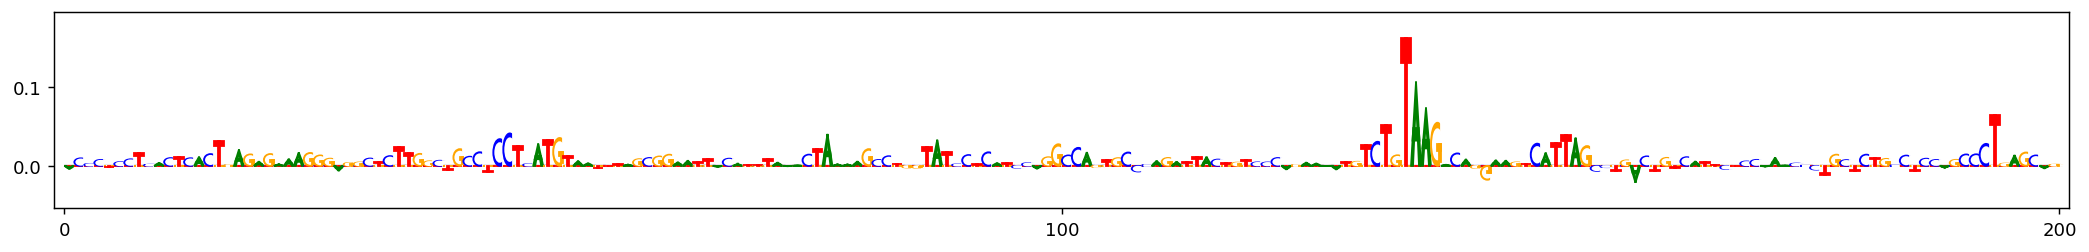

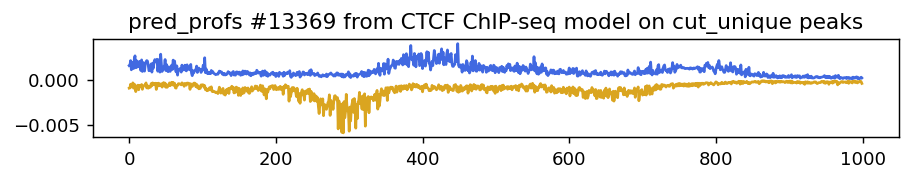

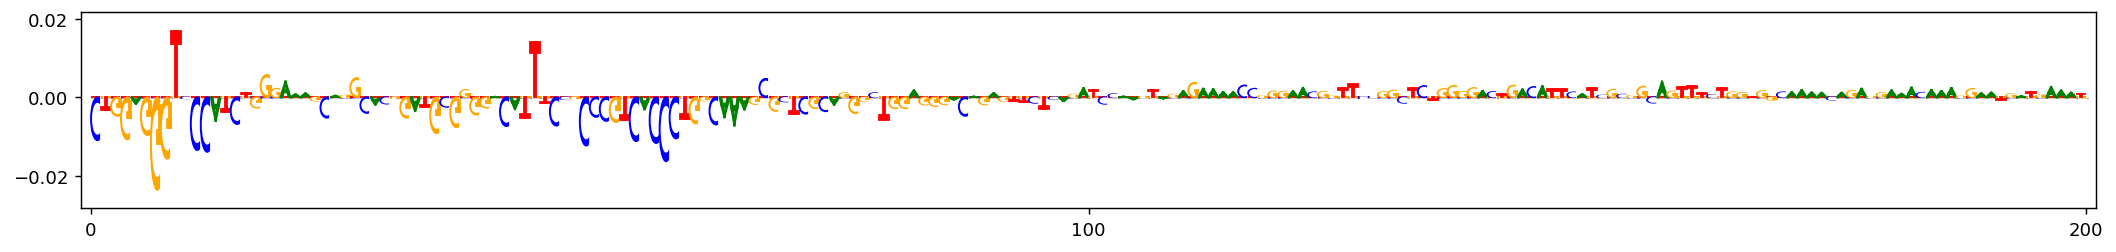

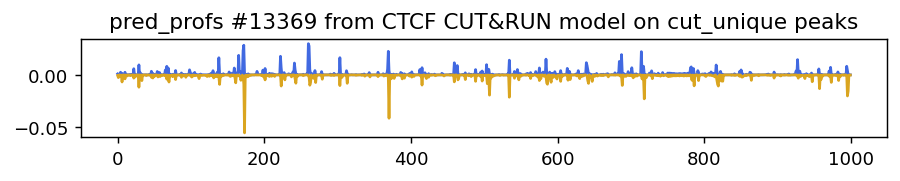

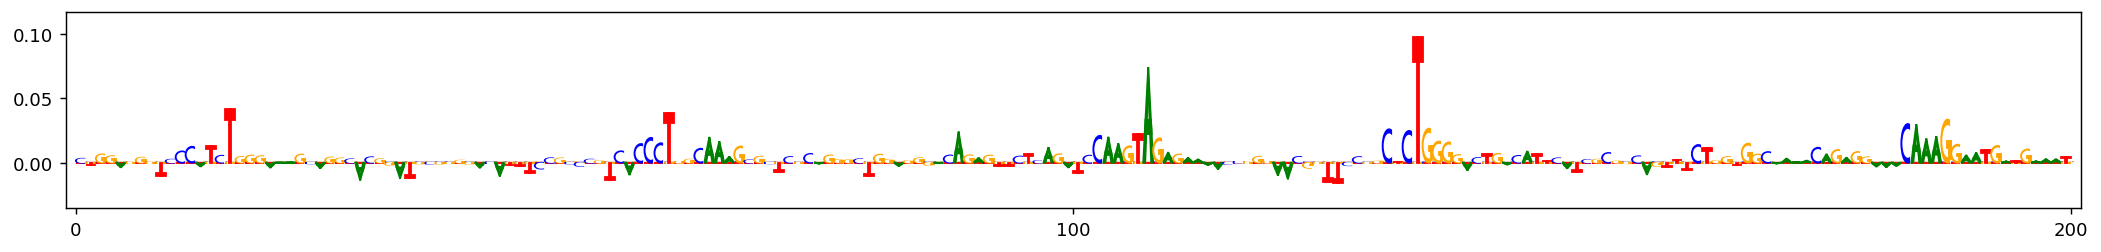

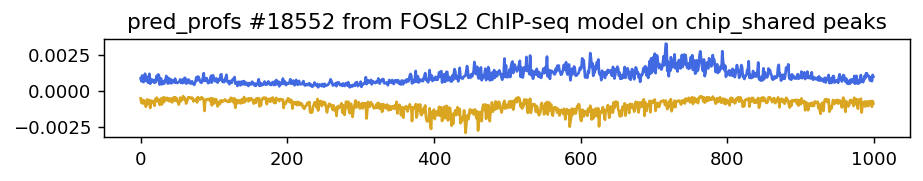

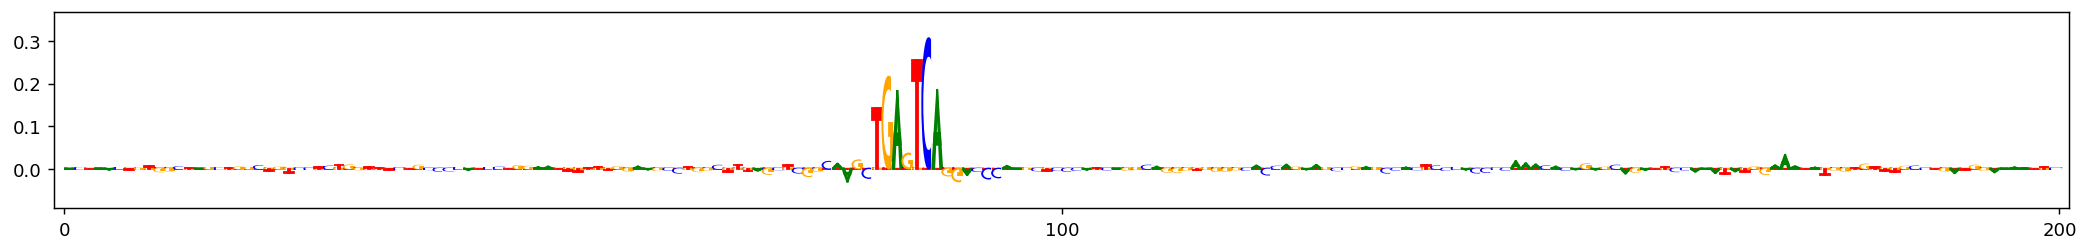

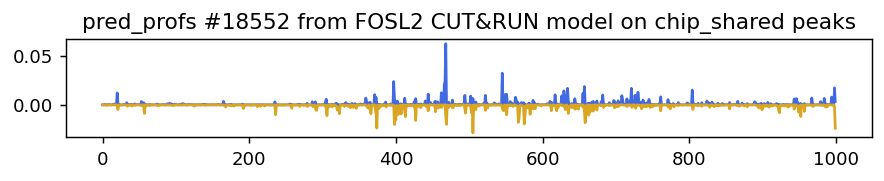

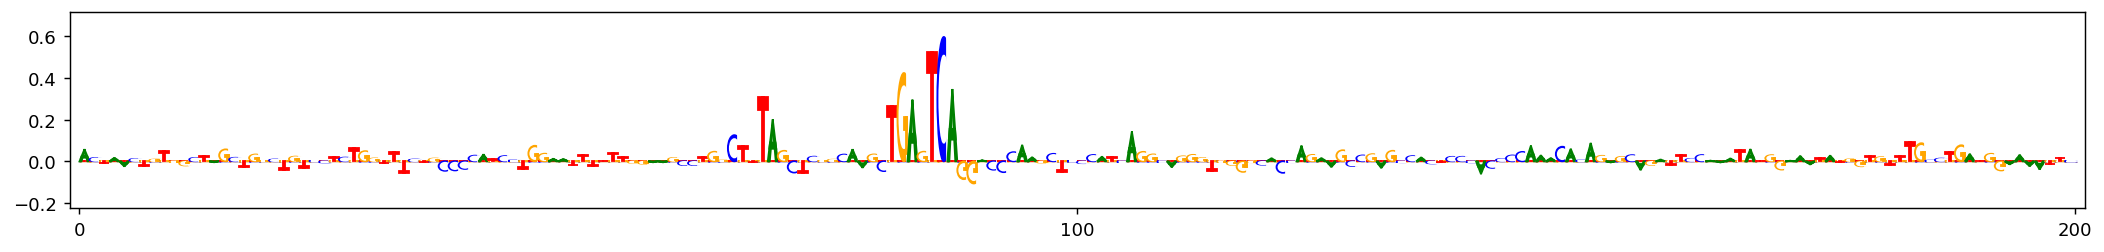

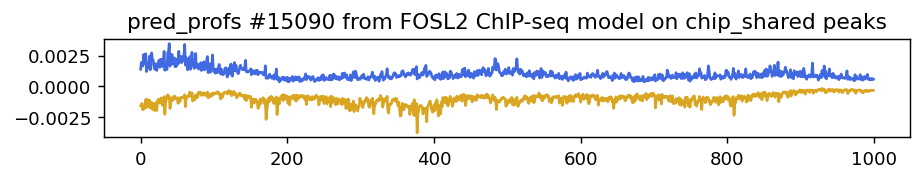

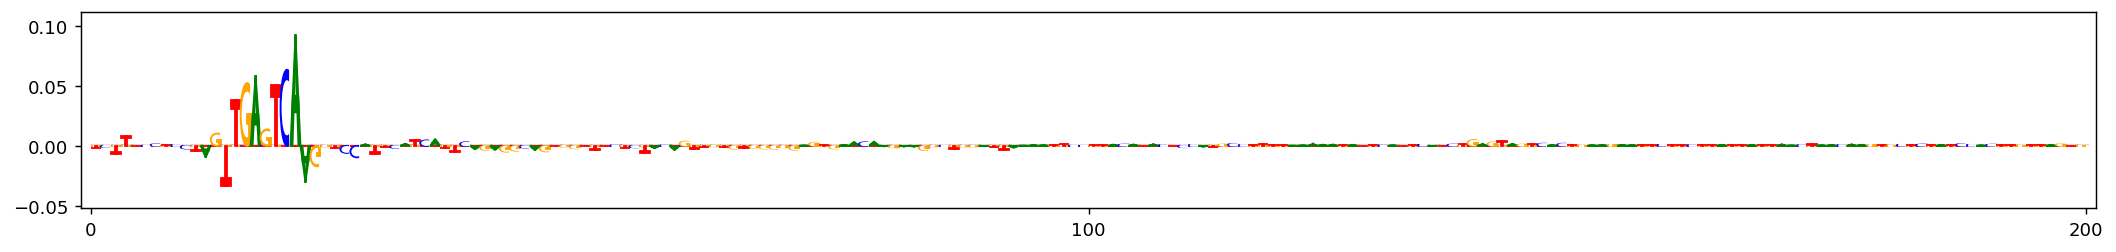

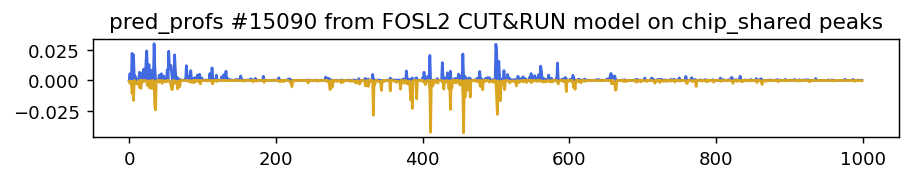

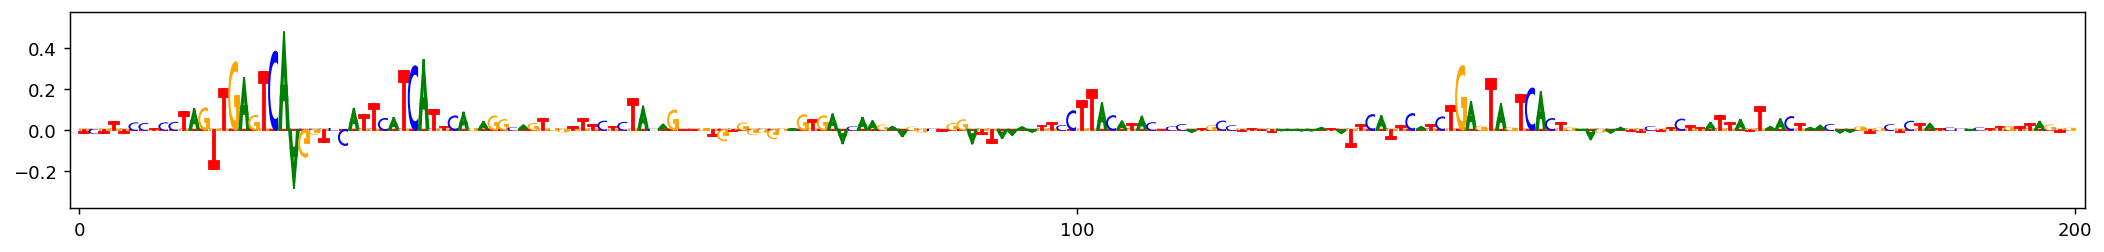

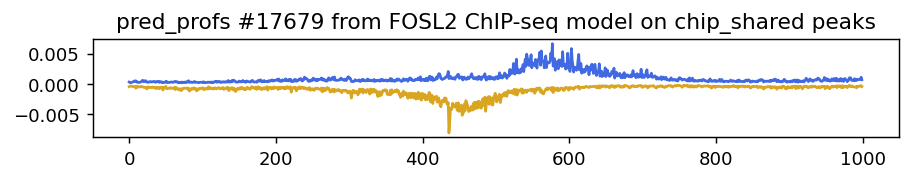

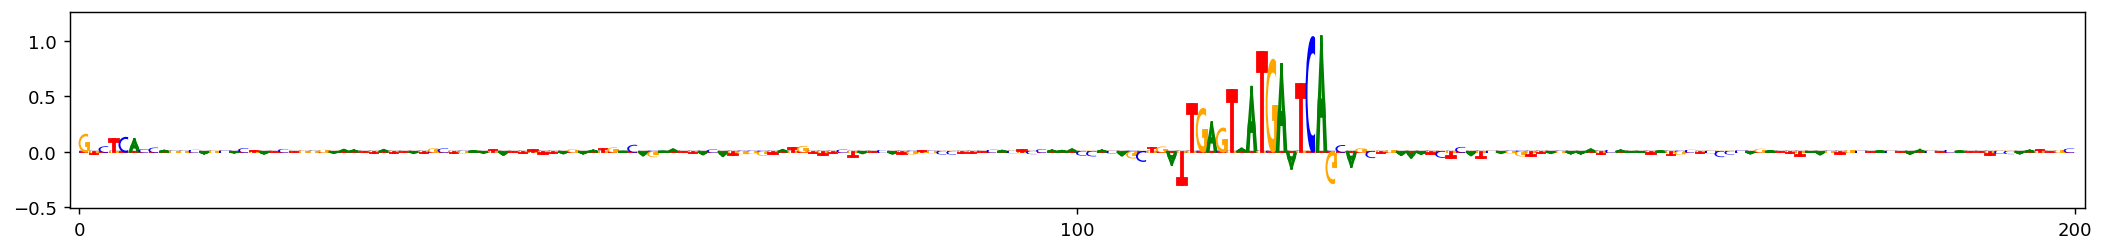

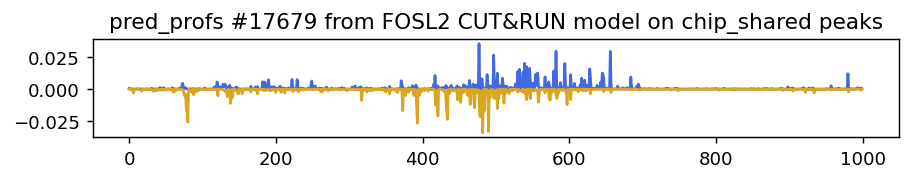

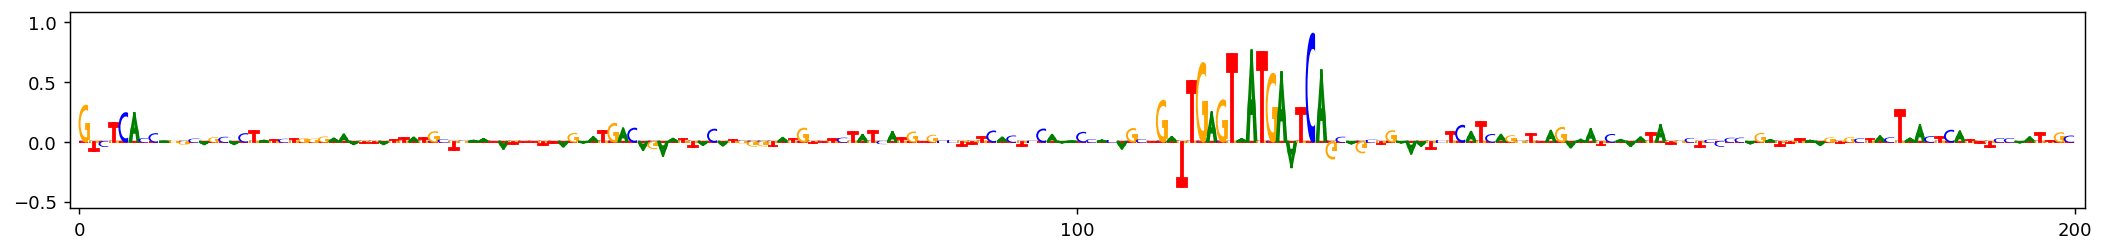

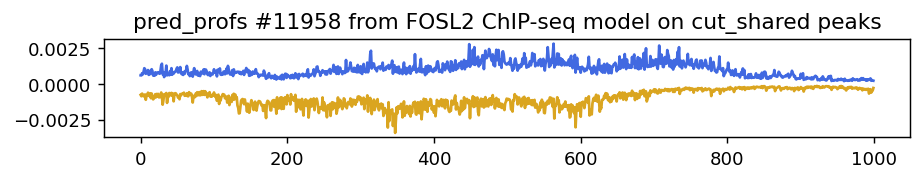

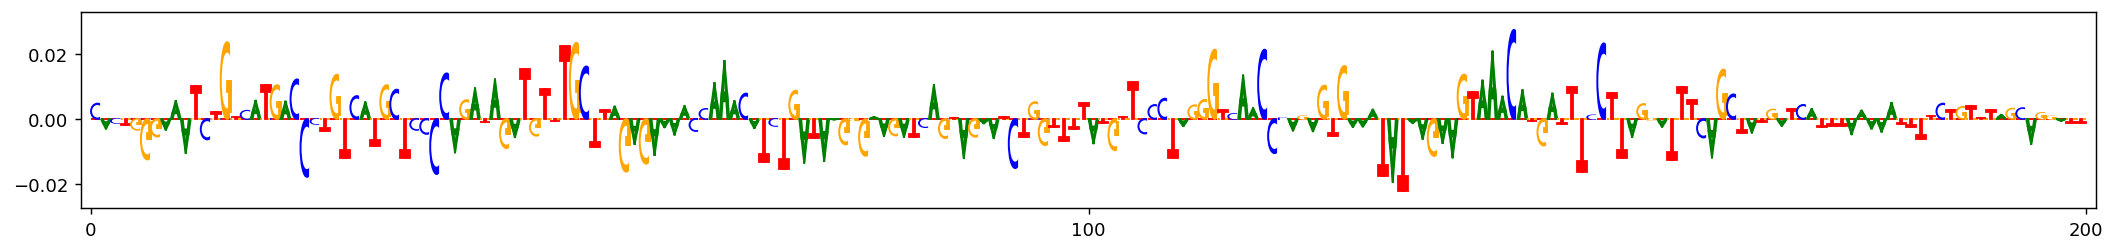

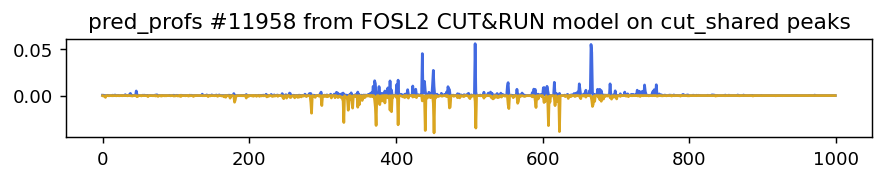

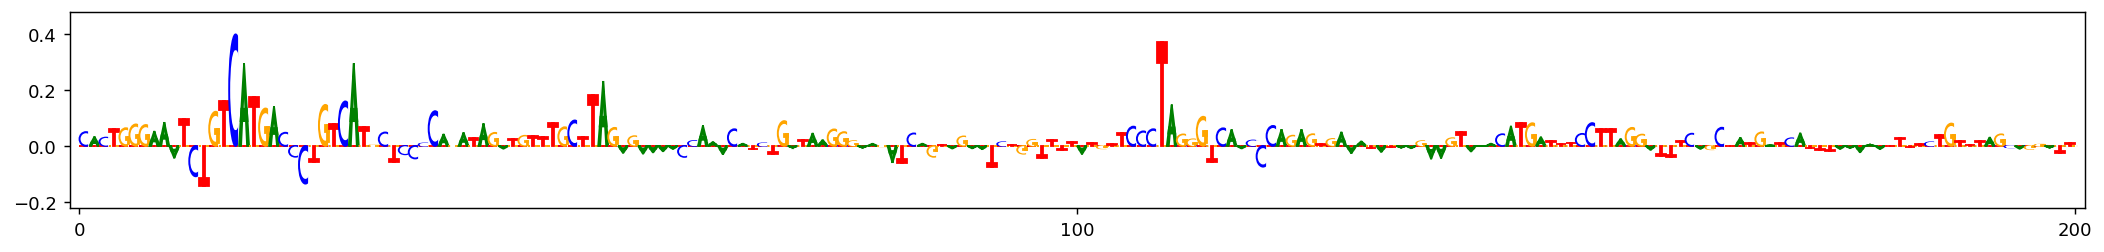

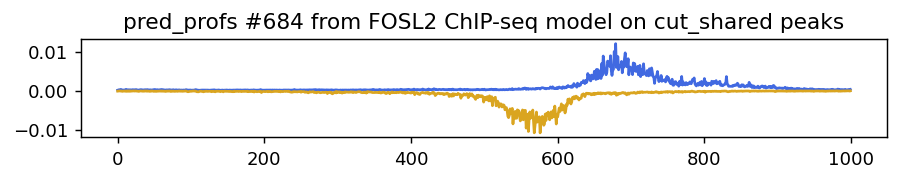

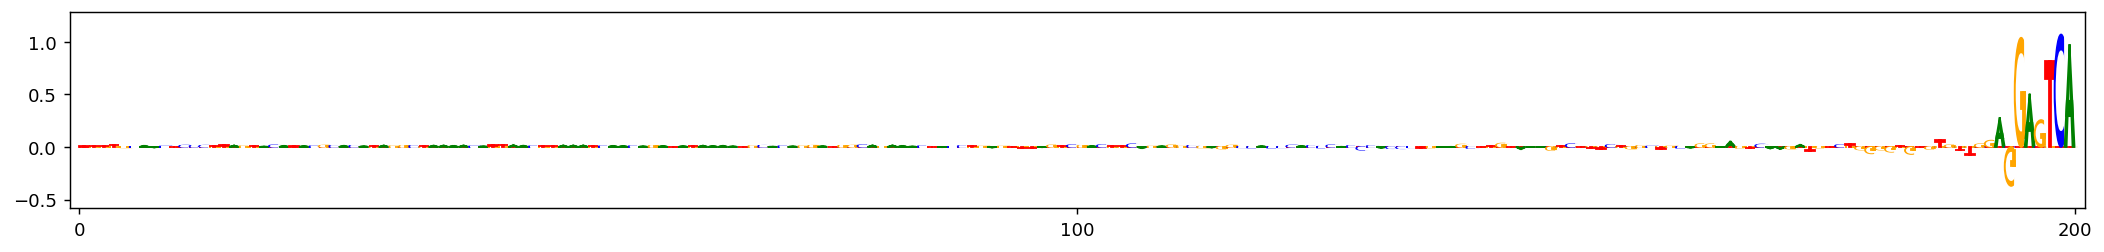

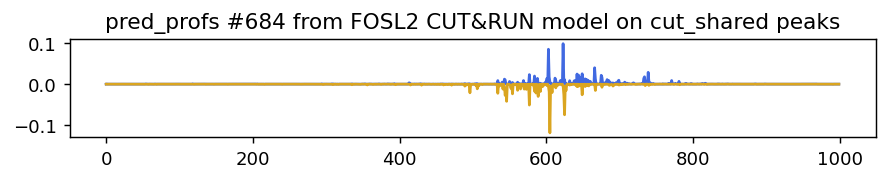

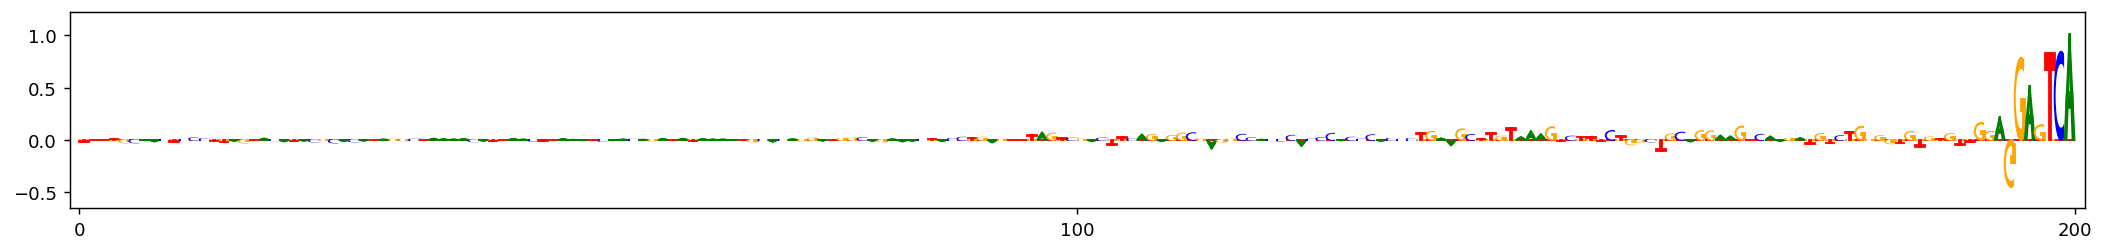

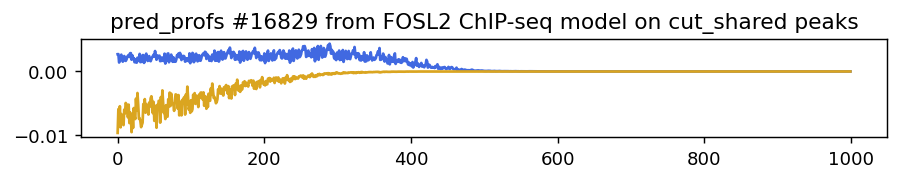

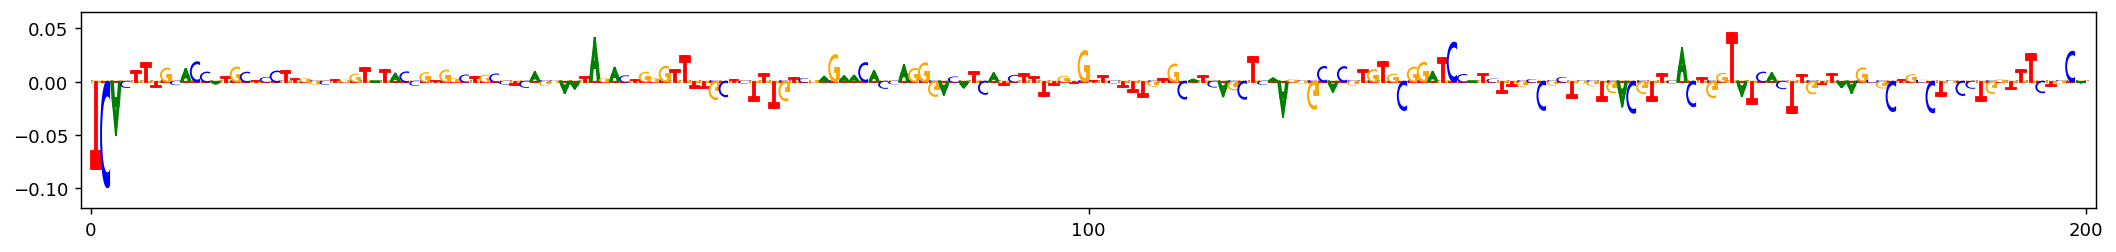

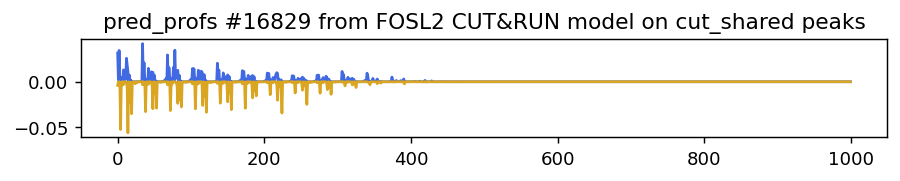

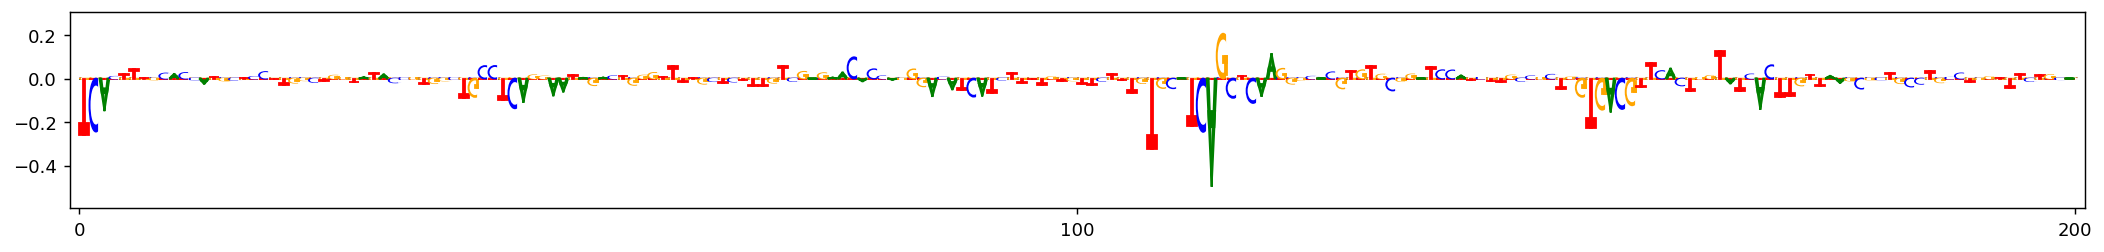

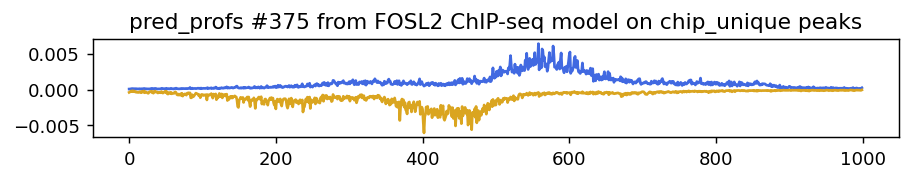

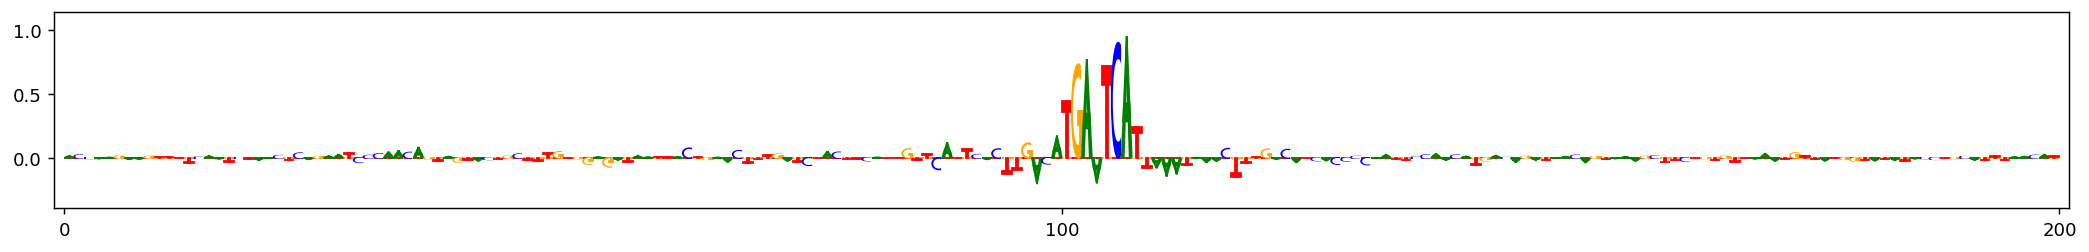

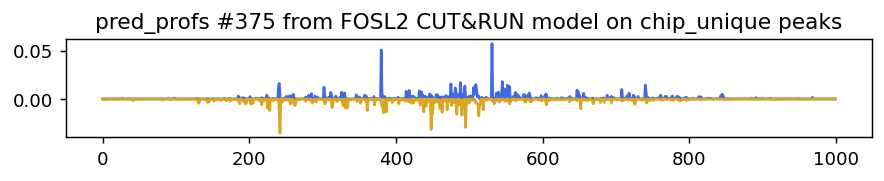

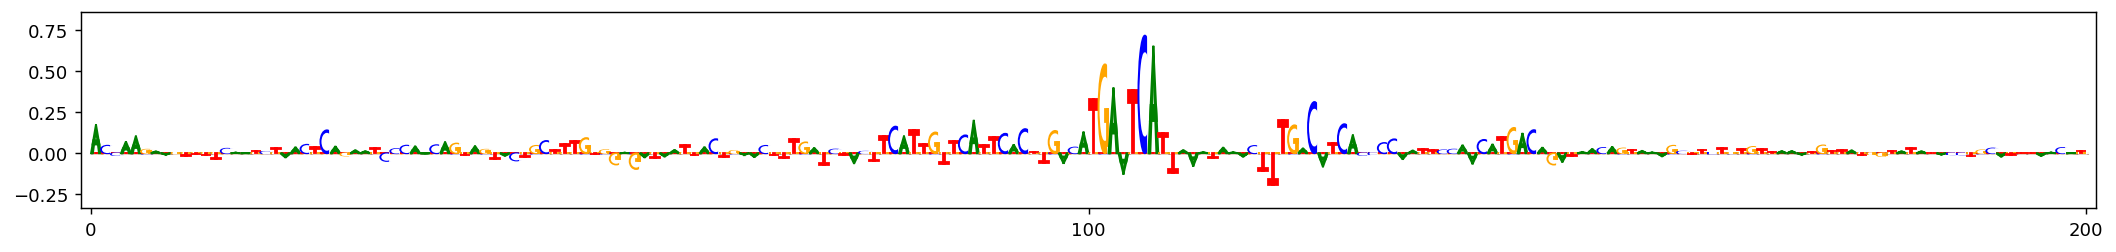

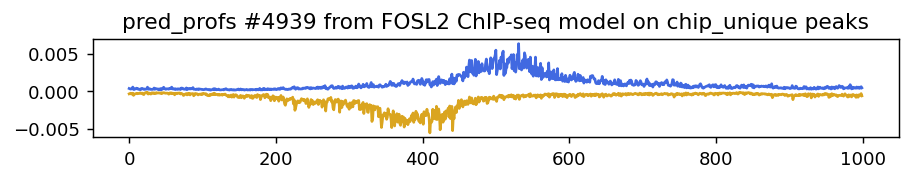

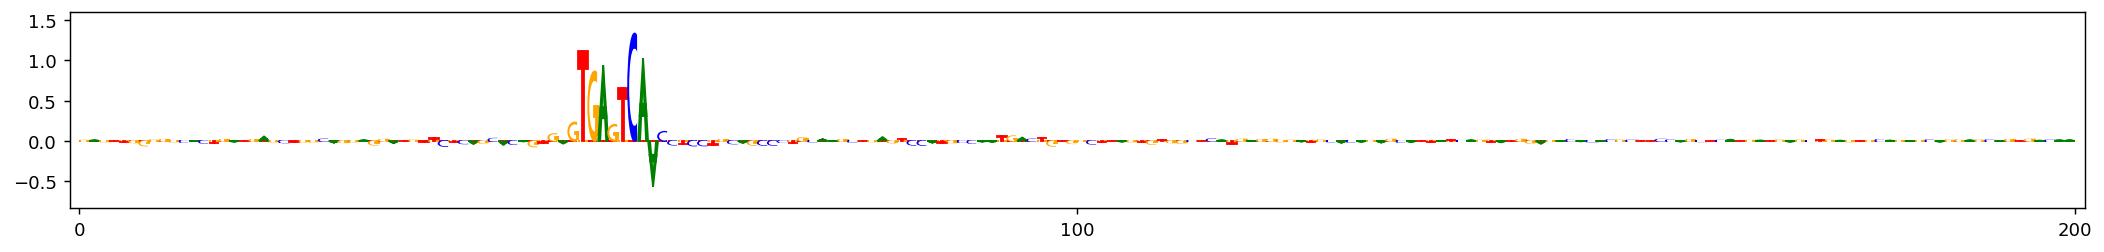

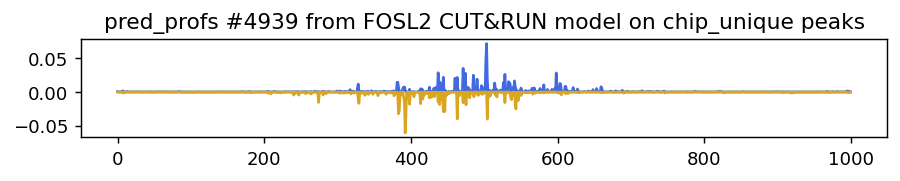

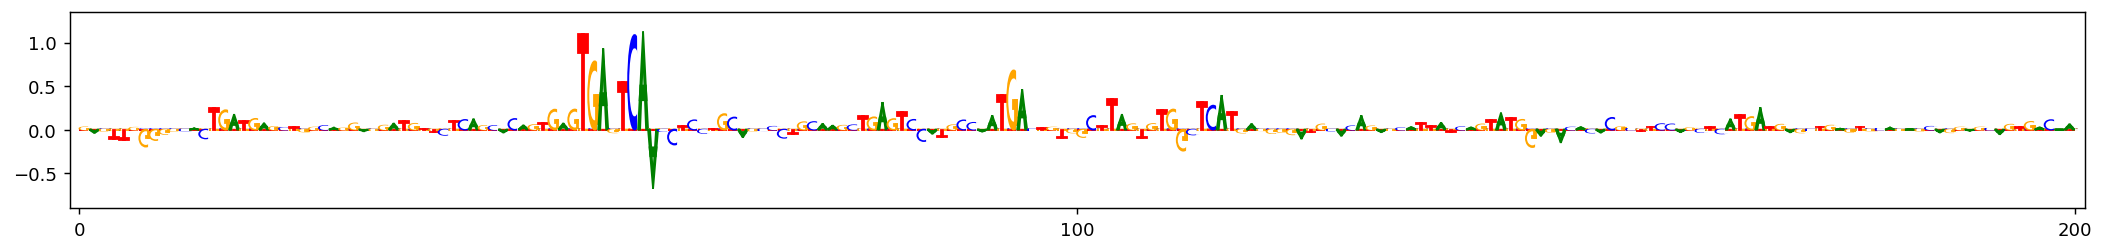

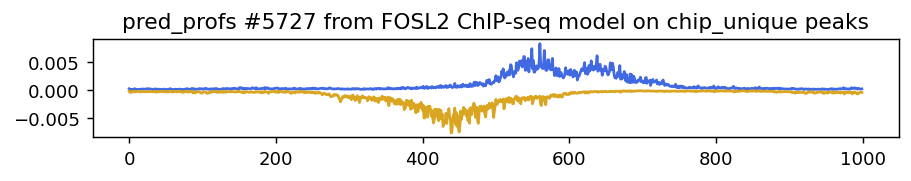

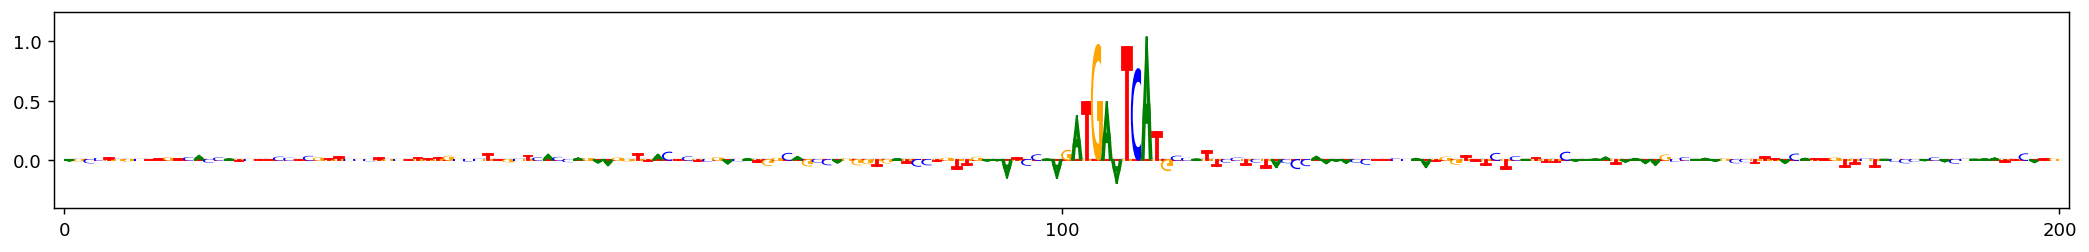

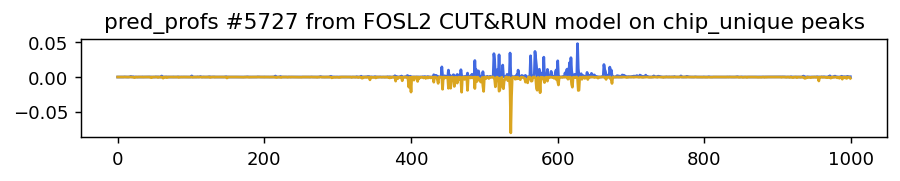

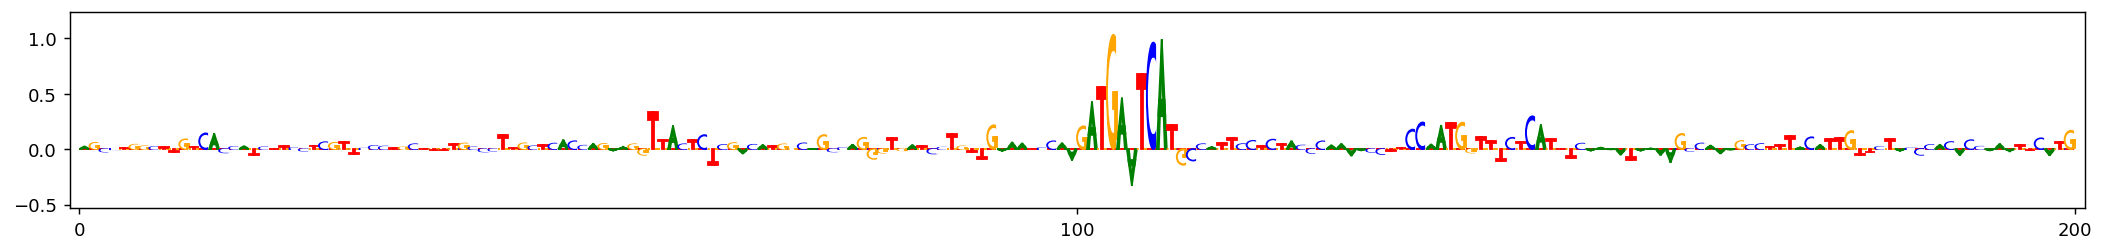

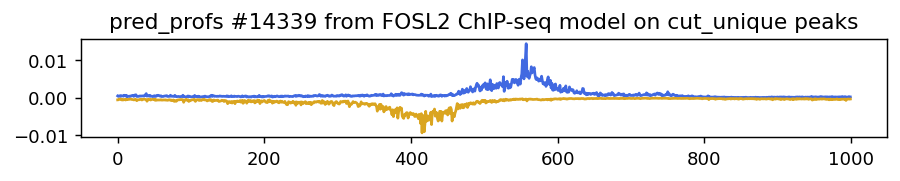

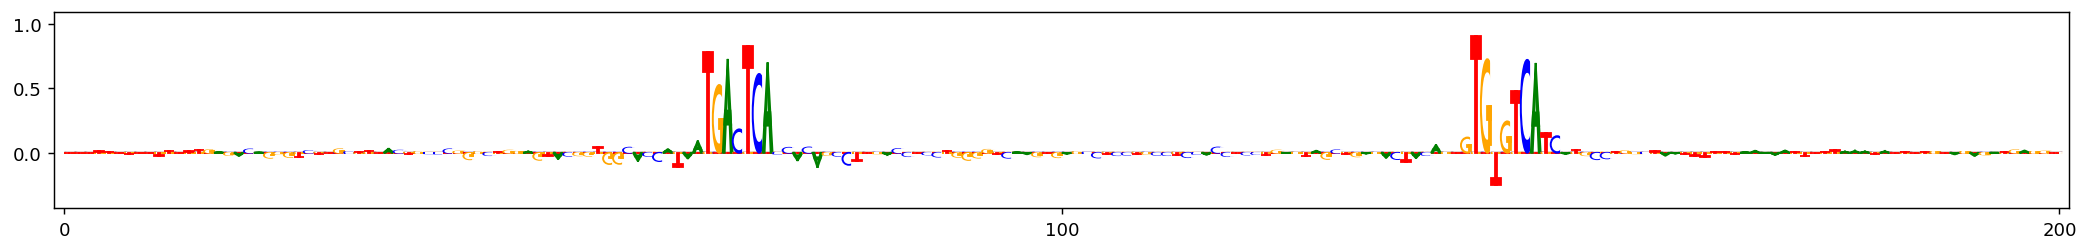

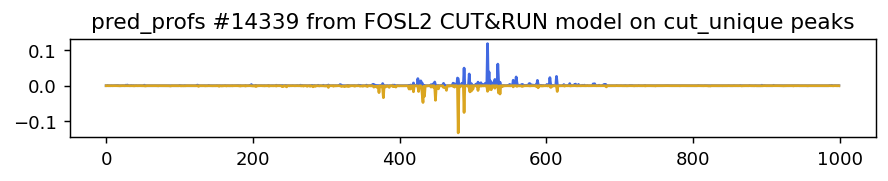

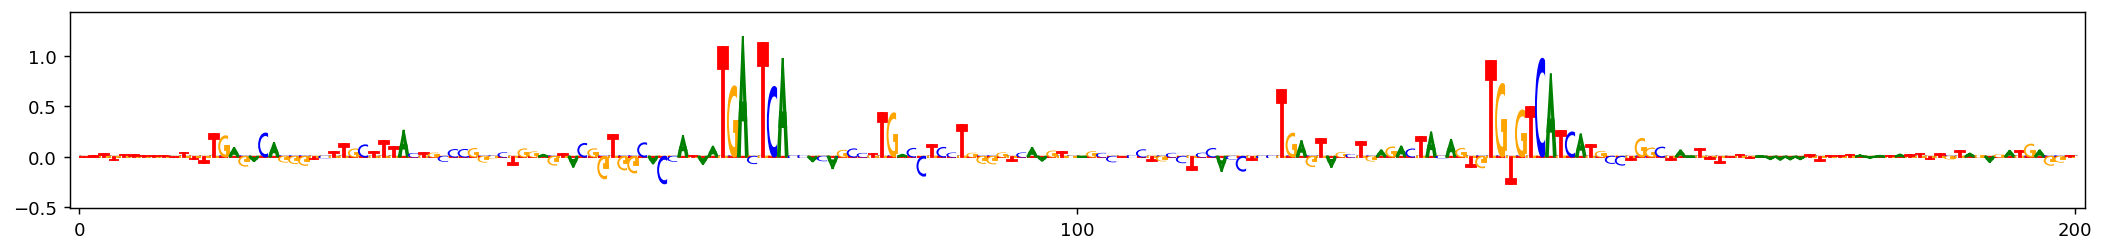

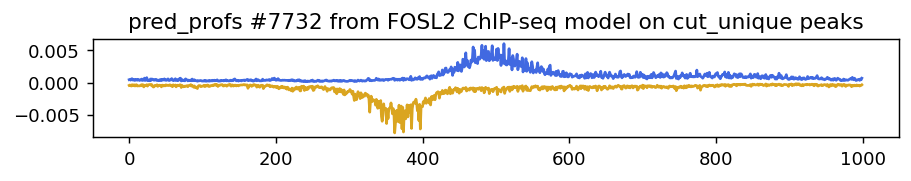

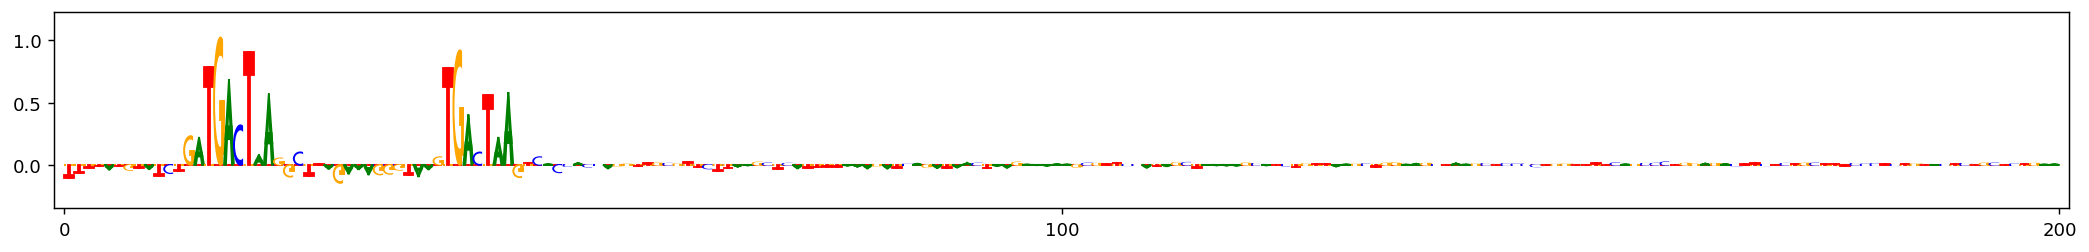

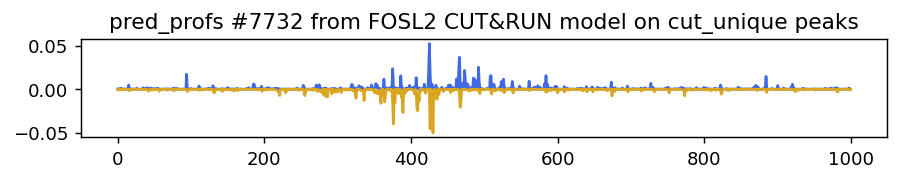

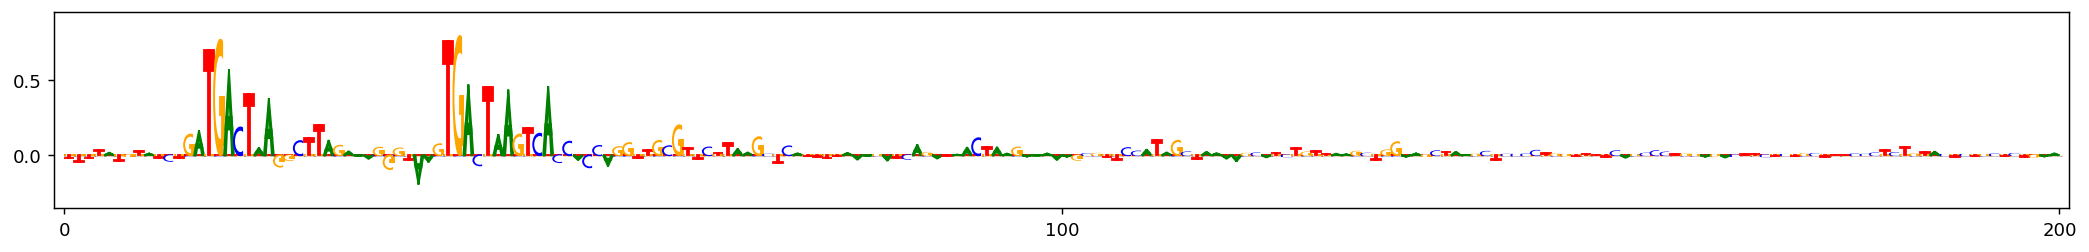

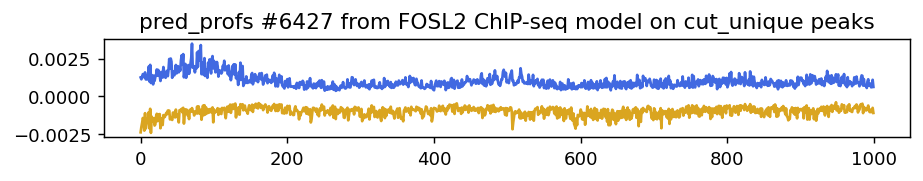

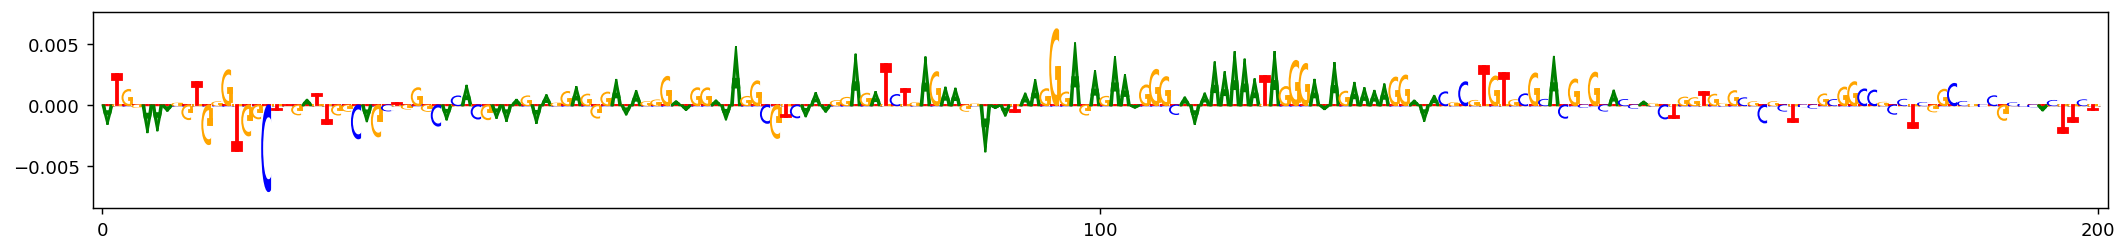

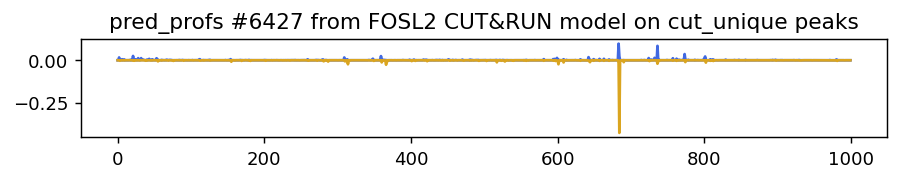

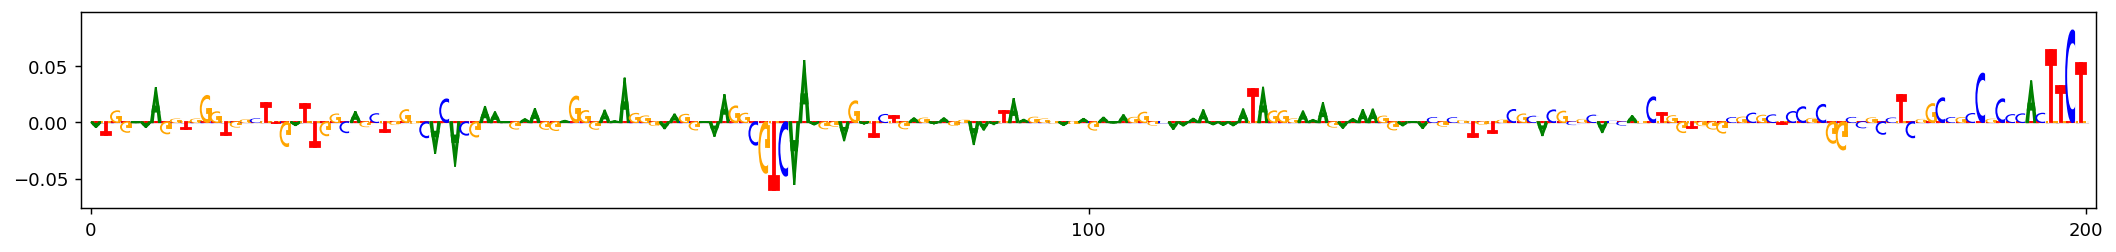

In [475]:
plot_examples_from_dict(preds_dict)